<h1 style="color:#0D2C54; font-size:50px">Data Mining Assignment</h1>
<h3 style="color:#F6511D; font-size:35">Ammar Alyousfi (WQD170064)</h3>
<h4 style="color:#00A6ED">Semester 2 of 2018/2019</h4>
<p style='text-align:left'><img src='i1.jpg' width='700' style='margin:0'></p>
<hr>

# Importing Libraries

In [368]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import re
from IPython.display import HTML
import sys
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [369]:
ax_facecolor = '#2D2D32ff'

# Creating "The Star" Stock Prices Table
We will create this table using the data we crawled from The Star website.

In [370]:
thestar_prices = pd.DataFrame(
    columns=['company_symbol', 'open_price', 'last_price', 
             'high_price', 'low_price', 'date', 'time'])

In [371]:
tmp_lsts = [[], [], [], [], [], [], []]
for file_name in os.listdir('Data/TheStar Stock Prices/'):
    if not file_name.startswith("prices_"):
        continue
    with open('Data/TheStar Stock Prices/' + file_name) as f:
        file_contents = [line.strip() for line in f.readlines()]
    for i in range(len(file_contents)):
        line_split = file_contents[i].split('[')
        symbol_prices = line_split[0].split(' : ')[:-1]
        company_symbol = symbol_prices[0]
        prices = symbol_prices[1:]
        prices = [float(x) if x != '-' else np.nan for x in prices]
        open_price = prices[0]
        high_price = prices[1]
        low_price = prices[2]
        last_price = prices[3]
        date = file_name.split('_')[1]
        time = (file_name.split('_')[2].replace('-', ':')
                .replace(".txt", ""))
        tmp_lsts[0].append(company_symbol)
        tmp_lsts[1].append(open_price)
        tmp_lsts[2].append(last_price)
        tmp_lsts[3].append(high_price)
        tmp_lsts[4].append(low_price)
        tmp_lsts[5].append(date)
        tmp_lsts[6].append(time)
        
for i, c in enumerate(thestar_prices.columns.values):
    thestar_prices[c] = tmp_lsts[i]

In [372]:
thestar_prices.shape

(888066, 7)

In [373]:
thestar_prices.company_symbol.unique().shape

(1854,)

This means that the table contains **888,066** records for **1,854** companies.

## A Sample of "The Star" Stock Prices Table

In [374]:
thestar_prices_sample = thestar_prices.loc[300:308, :]

styles = [
    dict(selector="td", props=[("border", "1px solid #333"), ("padding", "6px")]),
    dict(selector="th", props=[("border", "1px solid #333"), ("padding", "6px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "10px 16px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "10px 16px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "10px 16px")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

html = (thestar_prices_sample.style.set_table_styles(styles)
        .set_table_attributes('style="border-collapse: collapse"'))
html

,company_symbol,open_price,last_price,high_price,low_price,date,time
300,CMSB-C14,nan,0.085,nan,nan,18-May-2019,05:42
301,CMSB-C15,0.05,0.05,0.05,0.05,18-May-2019,05:42
302,CNASIA,0.43,0.43,0.44,0.43,18-May-2019,05:42
303,CNI,0.07,0.07,0.07,0.07,18-May-2019,05:42
304,CNOUHUA,0.045,0.045,0.045,0.045,18-May-2019,05:42
305,COASTAL,1.05,1.04,1.05,1.04,18-May-2019,05:42
306,COCOLND,1.96,1.96,1.96,1.96,18-May-2019,05:42
307,COMCORP,0.08,0.07,0.08,0.065,18-May-2019,05:42
308,COMFORT,0.83,0.825,0.84,0.825,18-May-2019,05:42


# Missin Values

In [375]:
na_values = thestar_prices.isna().sum(axis=1)
na_values[na_values > 0].shape

(389668,)

This means that 389,668 rows out of 888,066 rows have missing values due to data not available on the webiste sometimes.

In [376]:
na_values = thestar_prices.isna().sum(axis=0)
na_values.to_frame(name='missing_values')

,missing_values
company_symbol,0
open_price,389668
last_price,0
high_price,389668
low_price,389668
date,0
time,0


We can see that `last_price` column does not have any missing values. In fact, missing values exist only in `open_price`, `high_price`, and `low_price` columns. These missing values result when the source website shows only the last price without other prices.

## Keeping Only One Record Per Day

In [377]:
thestar_prices['date'] = pd.to_datetime(thestar_prices.date, 
                                        format='%d-%b-%Y')
thestar_prices['time'] = pd.to_datetime(thestar_prices.time, 
                                        format='%H:%M').dt.time

In [378]:
thestar_prices.sort_values(by=['date', 'time'], axis=0, 
                           ascending=True, inplace=True)

In [379]:
thestar_prices.drop_duplicates(subset=['company_symbol', 'date'], 
                               keep='last', inplace=True)

In [380]:
thestar_prices.shape

(155736, 7)

Now the table contains **155,736** records. This means that we have price data for 155736/1854 = **84** days for each company.

In [381]:
thestar_prices.reset_index(drop=True, inplace=True)
thestar_prices.index = thestar_prices.date

Taking a look at the table after this reduction process:

In [382]:
thestar_prices.head()

,company_symbol,open_price,last_price,high_price,low_price,date,time
date,,,,,,,
2019-02-23,3A,0.850,0.860,0.865,0.850,2019-02-23,17:57:00
2019-02-23,A50CHIN-C22,0.070,0.090,0.095,0.065,2019-02-23,17:57:00
2019-02-23,A50CHIN-C24,NaN,0.500,NaN,NaN,2019-02-23,17:57:00
2019-02-23,A50CHIN-C26,0.345,0.380,0.380,0.340,2019-02-23,17:57:00
2019-02-23,A50CHIN-C28,NaN,0.185,NaN,NaN,2019-02-23,17:57:00


# Creating "The Edge Markets" News Table
We will create this table using the news data we scraped from The Edge Markets website.

In [383]:
news = pd.read_csv('Data/theedgemarkets_news_corporate.csv')

In [384]:
NBA = NaiveBayesAnalyzer()

Adding a column to show the company full name:

In [385]:
company_symbols = []
with open("Data/company_symbols.txt") as f:
    for line in f:
        company_symbols.append(line.strip())

company_fullnames = []
with open("Data/company_fullnames.txt") as f:
    for line in f:
        company_fullnames.append(line.strip())

company_fullnames = [
    re.sub(r'(.*:\s*)|(\s*\(.*\))|(\s*BERHAD)|(\s*BHD)', '', com_fn) 
    for com_fn in company_fullnames]
company_fullnames = [re.sub(r'(^CW\s*)|(^PW\s*)', '', com_fn) 
                     for com_fn in company_fullnames]
company_fullnames = [x.lower() for x in company_fullnames]
symbols_fullnames = {}
for sym, fn in zip(company_symbols, company_fullnames):
    symbols_fullnames[sym] = fn

news['company_fullname'] = news['company_symbol'].map(symbols_fullnames)

## A Sample of "The Edge Markets" News Table

In [386]:
news_sample = news.head()
news_sample['text'] = news_sample['text'].apply(lambda x: x[:70] + '...')
html = (news_sample.style.set_table_styles(styles)
        .set_table_attributes('style="border-collapse: collapse"'))
html

,company_symbol,headline,url,datetime,text,in_headline,is_fullname,company_fullname
0,BURSA,Foreign funds turn net sellers as outflows exceed inflows,https://www.theedgemarkets.com/article/foreign-funds-turn-net-sellers-outflows-exceed-inflows,"March 29, 2019 21:28 pm +08",KUALA LUMPUR (March 29): Foreign institutions turned net sellers in th...,No,Yes,bursa malaysia
1,BURSA-C18,Foreign funds turn net sellers as outflows exceed inflows,https://www.theedgemarkets.com/article/foreign-funds-turn-net-sellers-outflows-exceed-inflows,"March 29, 2019 21:28 pm +08",KUALA LUMPUR (March 29): Foreign institutions turned net sellers in th...,No,Yes,bursa malaysia
2,BURSA-C20,Foreign funds turn net sellers as outflows exceed inflows,https://www.theedgemarkets.com/article/foreign-funds-turn-net-sellers-outflows-exceed-inflows,"March 29, 2019 21:28 pm +08",KUALA LUMPUR (March 29): Foreign institutions turned net sellers in th...,No,Yes,bursa malaysia
3,BURSA-C21,Foreign funds turn net sellers as outflows exceed inflows,https://www.theedgemarkets.com/article/foreign-funds-turn-net-sellers-outflows-exceed-inflows,"March 29, 2019 21:28 pm +08",KUALA LUMPUR (March 29): Foreign institutions turned net sellers in th...,No,Yes,bursa malaysia
4,BURSA-C22,Foreign funds turn net sellers as outflows exceed inflows,https://www.theedgemarkets.com/article/foreign-funds-turn-net-sellers-outflows-exceed-inflows,"March 29, 2019 21:28 pm +08",KUALA LUMPUR (March 29): Foreign institutions turned net sellers in th...,No,Yes,bursa malaysia


## Adding Sentiment to Each Record in the Table
We will apply sentiment analysis on each record of the news table and add columns that show the sentiment of the news in that record. To do sentiment analysis, we will use TextBlob Python library which has two sentiment analyzers: `PatternAnalyzer` which is based on the "pattern" library and `NaiveBayesAnalyzer` which is an NLTK-library classifier trained on a movie reviews corpus.

In [387]:
def get_excerpt(row, limit=200):
    if row.in_headline == 'No':
        if row.is_fullname == 'Yes': 
            ind = row.text.lower().find(row.company_fullname.lower())
        elif row.is_fullname == 'No': 
            ind = row.text.lower().find(row.company_symbol.lower())
        excerpt = row.text[ind-limit:ind+limit]
        if (ind-limit) < 0:
            excerpt = row.text[:ind+limit]
        if (ind+limit) > (len(row.text)-1):
            excerpt = row.text[ind-limit:]
        # to get rid of half sentences
        if len(excerpt.split('.', 1)) > 1:
            excerpt = excerpt.split('.', 1)[1]
        if len(excerpt.rsplit('.', 1)) > 1:
            excerpt = excerpt.rsplit('.', 1)[0]
        return excerpt
    else:
        return ""

def get_sentiment_1(row):
    if row.in_headline == 'Yes':
        sentiment_text = row.headline
    else:
        sentiment_text = row.excerpt
    pattern_sentiment = TextBlob(sentiment_text)
    pattern_sentiment = pattern_sentiment.sentiment.polarity
    return pattern_sentiment

In [388]:
news['excerpt'] = news.apply(func=get_excerpt, axis=1)
news['sentiment_1'] = news.apply(func=get_sentiment_1, axis=1)

In [389]:
news['datetime'] = news.datetime.str.replace(r'am', r'AM')
news['datetime'] = news.datetime.str.replace(r'pm', r'PM')
news['datetime'] = news.datetime.str.replace(r' (AM|PM) \+\d\d$', '')
news['date'] = pd.to_datetime(news.datetime, 
                              format='%B %d, %Y %H:%M').dt.date
news['time'] = pd.to_datetime(news.datetime, 
                              format='%B %d, %Y %H:%M').dt.time

Taking a look at the data after applying sentiment analysis:

In [390]:
news_sample = news.head()
html = (news_sample.style.set_table_styles(styles)
        .set_table_attributes('style="border-collapse: collapse"'))
html

In [391]:
news.shape

(362740, 12)

This means that we have **362,740** records in the news table. Each record represent a news item about some company. This news item might be a news headline or a part of a news article.

In [392]:
companies_with_most_news = (news.company_symbol.value_counts(sort=True)
                            .head(200).index.values)

## Keeping Only Records that Represent News Headlines
For better interpretability, we will keep only records that contain news headlines. We will remove records that contain parts of news articles.

In [393]:
news_headlines = news[news.in_headline == 'Yes']

In [394]:
news_headlines.shape

(45952, 12)

This means that we have **45,952** news headlines in the table. Each headline is related to one company.

In [395]:
companies_with_most_headlines = (news_headlines.company_symbol
                                 .value_counts(sort=True).head(200)
                                 .index.values)

## Creating a Table of Stock Prices and News Sentiment

In [396]:
news['date'] = news['date'].astype(str)
news_headlines['date'] = news_headlines['date'].astype(str)
news_grouped_s1 = (news.groupby(['company_symbol', 'date'])
                   ['sentiment_1'].mean())
headlines_grouped_s1 = (news_headlines.groupby(['company_symbol', 'date'])
                        ['sentiment_1'].mean())

In [397]:
f_df = thestar_prices.copy()
f_df['date'] = f_df['date'].astype(str)
f_df.reset_index(drop=True, inplace=True)
f_df['news_sentiment_1'] = 0.0
f_df['headlines_sentiment_1'] = 0.0
for i in range(f_df.shape[0]):
    row = f_df.iloc[i, :]
    c_s = row.company_symbol
    d = row.date
    try:
        n_s = news_grouped_s1[c_s][d]
        f_df.at[i, 'news_sentiment_1'] = n_s
    except:
        f_df.at[i, 'news_sentiment_1'] = 0.0
    try:
        n_s = headlines_grouped_s1[c_s][d]
        f_df.at[i, 'headlines_sentiment_1'] = n_s
    except:
        f_df.at[i, 'headlines_sentiment_1'] = 0.0

In [398]:
f_df.drop('time', axis=1, inplace=True)

Taking a look at the resulting table:

In [399]:
f_df.iloc[8000:8005]

,company_symbol,open_price,last_price,high_price,low_price,date,news_sentiment_1,headlines_sentiment_1
8000,GENM-C49,0.195,0.205,0.205,0.195,2019-02-27,0.140774,0.125
8001,GENM-C50,0.175,0.185,0.185,0.175,2019-02-27,0.140774,0.125
8002,GENM-C51,0.135,0.145,0.145,0.135,2019-02-27,0.140774,0.125
8003,GENP,10.400,10.520,10.540,10.400,2019-02-27,-0.008333,0.000
8004,GENP-WA,2.650,2.660,2.660,2.650,2019-02-27,0.000000,0.000


Creating a separate table for each company:

In [400]:
grouped = f_df.groupby('company_symbol')

In [401]:
(grouped.get_group('TM').iloc[1:10].style.set_table_styles(styles)
.set_table_attributes('style="border-collapse: collapse"'))

,company_symbol,open_price,last_price,high_price,low_price,date,news_sentiment_1,headlines_sentiment_1
3514,TM,3.09,3.11,3.12,3.06,2019-02-24,0,0
5368,TM,3.11,3.05,3.12,3.05,2019-02-25,0,0
7222,TM,3.06,3.02,3.06,2.97,2019-02-26,0,0
9076,TM,2.97,2.96,2.98,2.91,2019-02-27,-0.00625,-0.00833333
10930,TM,2.95,3.05,3.08,2.94,2019-02-28,-0.0388889,-0.0518519
12784,TM,3.05,3.03,3.05,2.99,2019-03-03,0,0
14638,TM,2.99,3.09,3.1,2.99,2019-03-04,-0.0689394,0
16492,TM,3.08,3.19,3.21,3.07,2019-03-05,0.125,0
18346,TM,3.19,3.24,3.28,3.15,2019-03-06,0,0


Taking a look at the table of some company:

In [402]:
for name, group in grouped:
    print("Company:", name)
    print("Data for", group.shape[0], "days", end=" ")
    print("since", group.date.values[0], "and until", 
          group.date.values[-1])
    html = (group.head(10).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse"'))
    display(html)
    break

Company: 3A
Data for 84 days since 2019-02-23 and until 2019-05-19


,company_symbol,open_price,last_price,high_price,low_price,date,news_sentiment_1,headlines_sentiment_1
0,3A,0.85,0.86,0.865,0.85,2019-02-23,0,0
1854,3A,0.85,0.86,0.865,0.85,2019-02-24,0,0
3708,3A,0.855,0.86,0.86,0.855,2019-02-25,0,0
5562,3A,0.86,0.845,0.86,0.845,2019-02-26,0,0
7416,3A,0.845,0.86,0.87,0.835,2019-02-27,0,0
9270,3A,0.865,0.855,0.87,0.855,2019-02-28,0,0
11124,3A,0.84,0.84,0.85,0.84,2019-03-03,0,0
12978,3A,0.84,0.855,0.855,0.84,2019-03-04,0,0
14832,3A,nan,0.855,nan,nan,2019-03-05,0,0
16686,3A,0.845,0.84,0.845,0.84,2019-03-06,0,0


So each company has data for **84 days since 2019-02-23 and until 2019-05-19 with two days missing**.

In [403]:
# abs sum of sentiments of companies
sen_sum = [[], []]
for name, group in grouped:
    c = 0
    for x in group['headlines_sentiment_1']:
        c += np.abs(x)
    sen_sum[0].append(name)
    sen_sum[1].append(c)

In [404]:
companies_with_sentiment = [c for c, s in zip
                            (sen_sum[0], sen_sum[1]) if s > 1.5]

## Time Series of Stock Prices and Sentiment Polarity

In [405]:
def price_sentiment(comp_sym):
    tg = grouped.get_group(comp_sym)
    tg.index = pd.to_datetime(tg.date)
    fig, ax1 = plt.subplots(figsize=(15, 9), facecolor=ax_facecolor);
    color='#1976d2'
    ax1.set_facecolor(ax_facecolor)
    ax1.set_title('Stock Price and Sentiment Polarity of ' + comp_sym,
                  fontsize=16, color='#bdbdbd')
    ax1.plot(tg.last_price, color=color, linewidth=3);
    ax1.set_xlabel("Date", labelpad=16, fontsize=16, color='#bdbdbd');
    ax1.tick_params(axis='x', labelcolor='#bdbdbd')
    ax1.set_ylabel("Stock Price", color=color, labelpad=16, fontsize=16);
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax1.twinx()
    color='#f4511e'
    ax2.plot(tg.headlines_sentiment_1, color=color, linewidth=3);
    ax2.set_ylabel("Sentiment", color=color, labelpad=16, fontsize=16)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.spines['bottom'].set_color(ax_facecolor)
    ax2.spines['top'].set_color(ax_facecolor) 
    ax2.spines['right'].set_color(ax_facecolor)
    ax2.spines['left'].set_color(ax_facecolor)
    corr_ = np.round(np.corrcoef(tg.last_price, 
                                 tg.headlines_sentiment_1)[0][1], 4)
    display(HTML("<p>Correlation between the stock price and news " + 
                 "sentiment of this company = " + 
                 str(corr_) + "</p"))

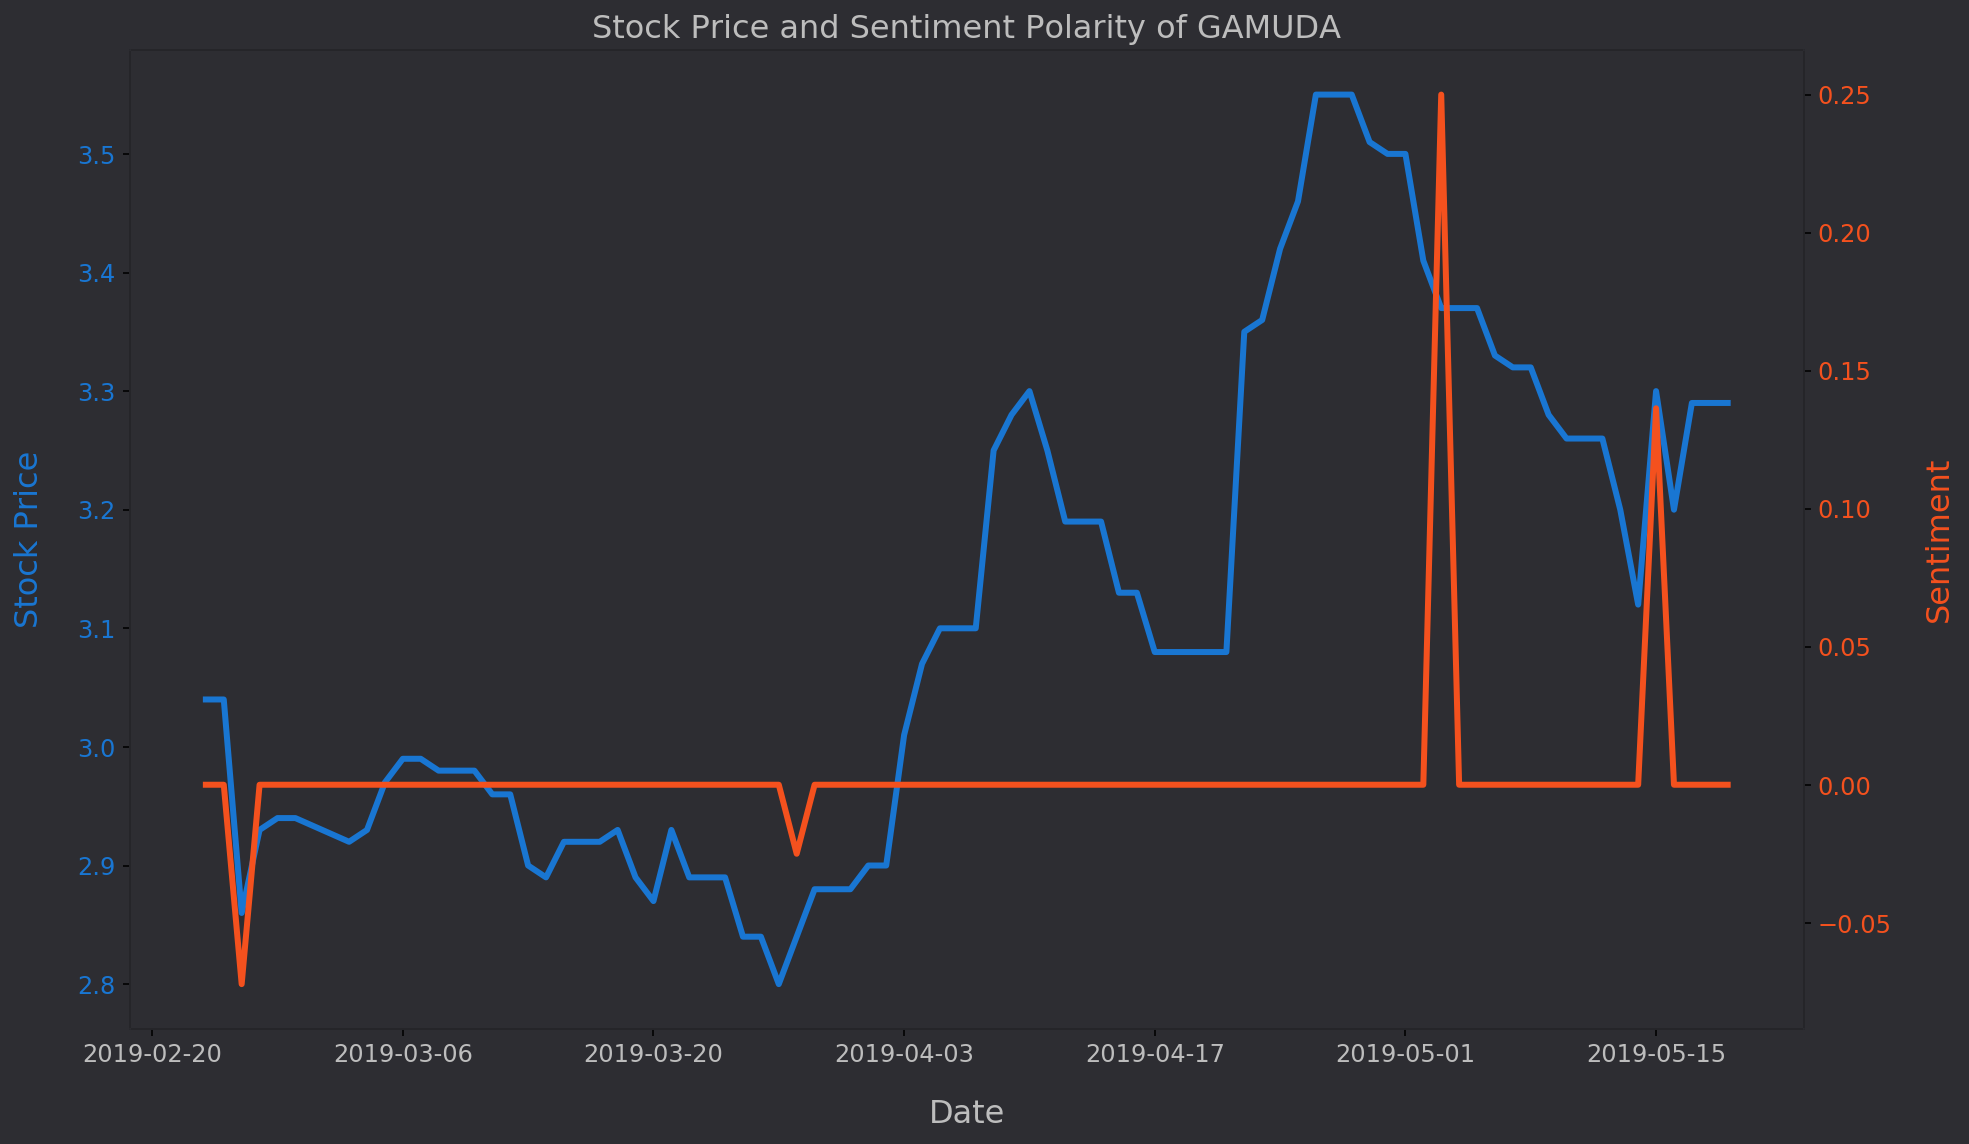

In [406]:
price_sentiment('GAMUDA')

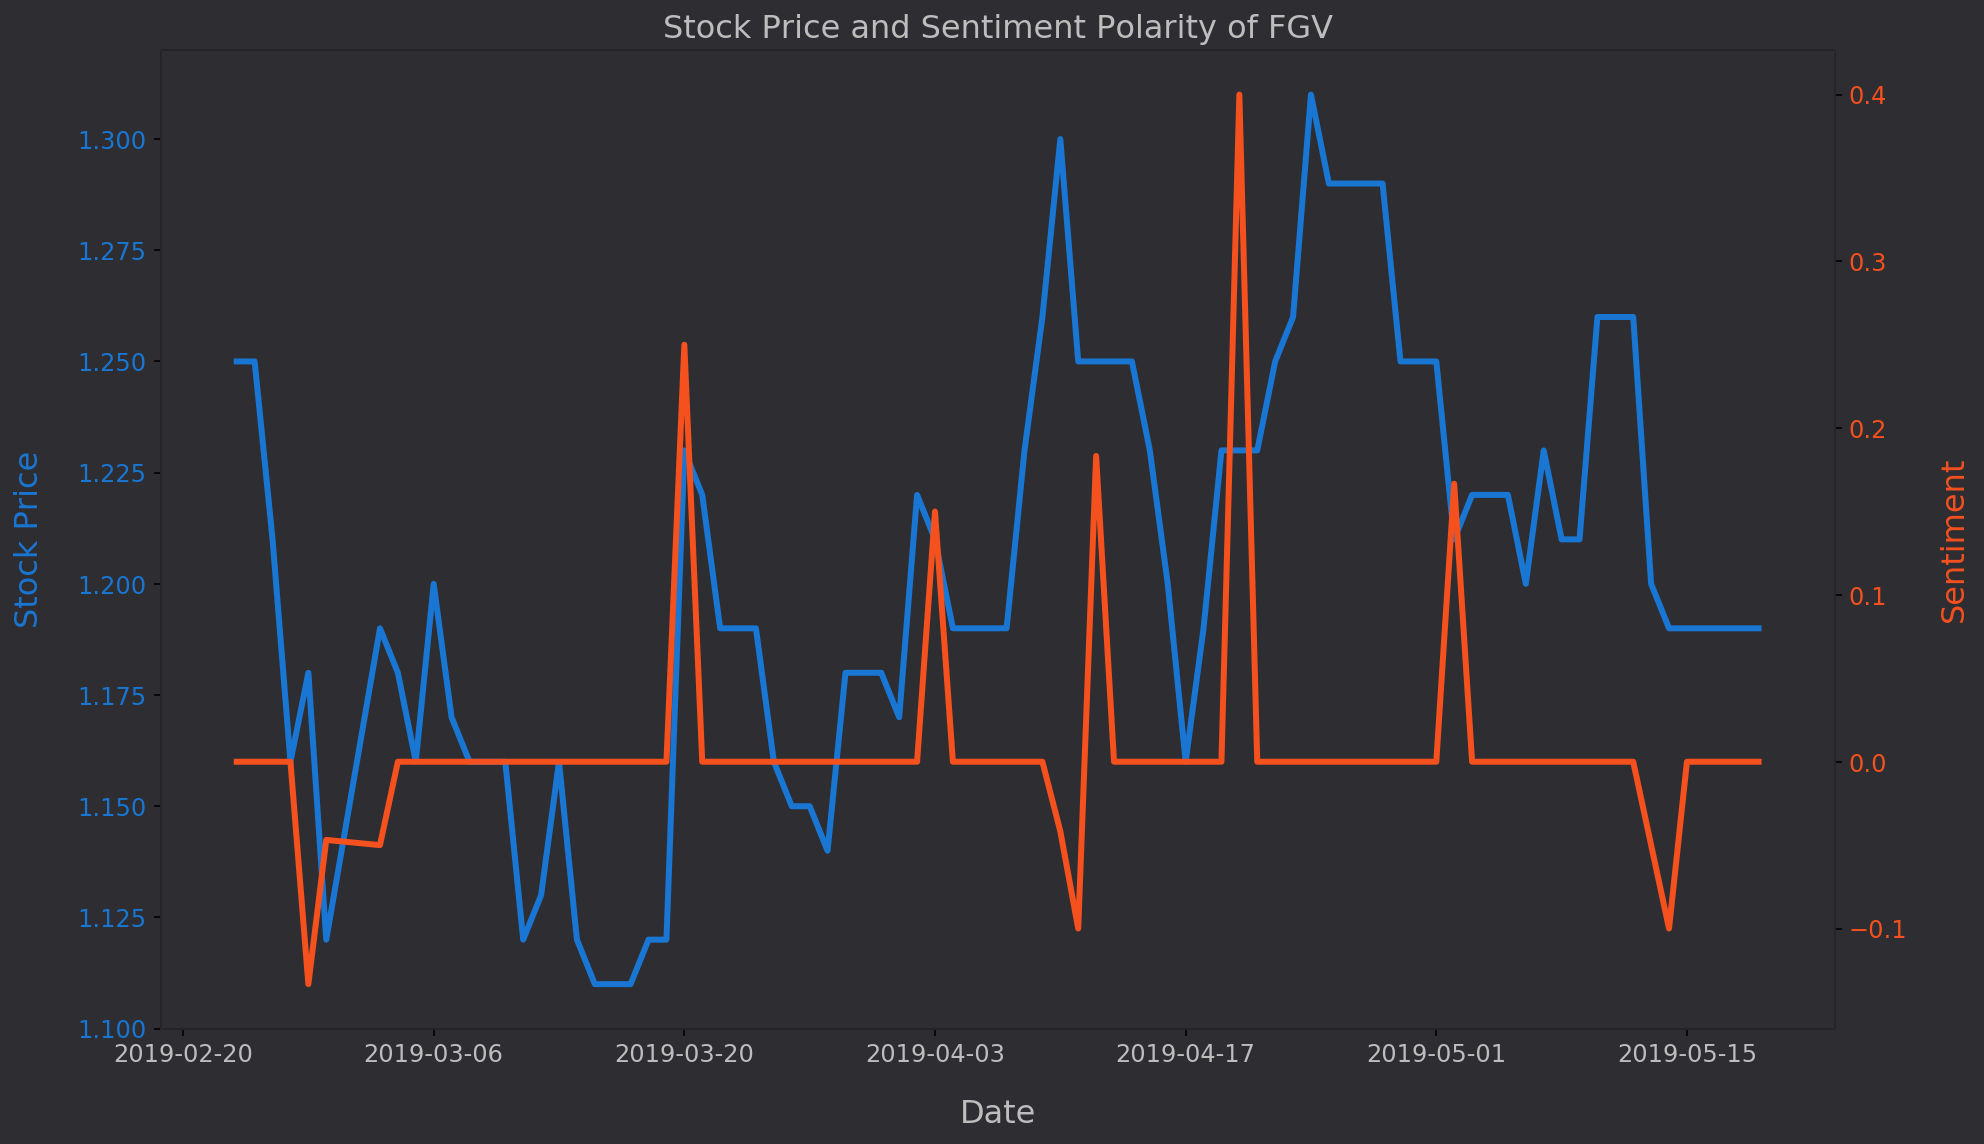

In [407]:
price_sentiment('FGV')

## Stock Price Comparison

In [408]:
def compare_stock_prices(comp_sym_1, comp_sym_2, alpha=1.0):
    company_1 = comp_sym_1
    company_2 = comp_sym_2
    c1 = grouped.get_group(company_1)
    c2 = grouped.get_group(company_2)
    c1.index = pd.to_datetime(c1.date)
    c2.index = pd.to_datetime(c2.date)
    fig, ax1 = plt.subplots(figsize=(15, 9), facecolor=ax_facecolor);
    color='#ffb300'
    ax1.set_facecolor(ax_facecolor)
    ax1.set_title('Stock Prices of ' + comp_sym_1 + ' and ' + 
                  comp_sym_2, fontsize=16, color='#bdbdbd')
    ax1.plot(c1.last_price, color=color, alpha=alpha, linewidth=3);
    ax1.set_xlabel("Date", labelpad=16, fontsize=16, color='#bdbdbd');
    ax1.tick_params(axis='x', labelcolor='#bdbdbd')
    ax1.set_ylabel(company_1 + " Stock Price", color=color, 
                   labelpad=16, fontsize=16)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(True, color='#4d4a50')
    ax2 = ax1.twinx()
    color='#388e3c'
    ax2.plot(c2.last_price, color=color, alpha=alpha, linewidth=3);
    ax2.set_ylabel(company_2 + " Stock Price", color=color, 
                   labelpad=16, fontsize=16)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.spines['bottom'].set_color(ax_facecolor)
    ax2.spines['top'].set_color(ax_facecolor) 
    ax2.spines['right'].set_color(ax_facecolor)
    ax2.spines['left'].set_color(ax_facecolor)
    corr_ = np.round(np.corrcoef(
        c1.last_price, c2.last_price)[0][1], 4)
    display(HTML("<p>Correlation between the stock prices of" + 
                 " the two companies = " + 
                 str(corr_) + "</p"))
    

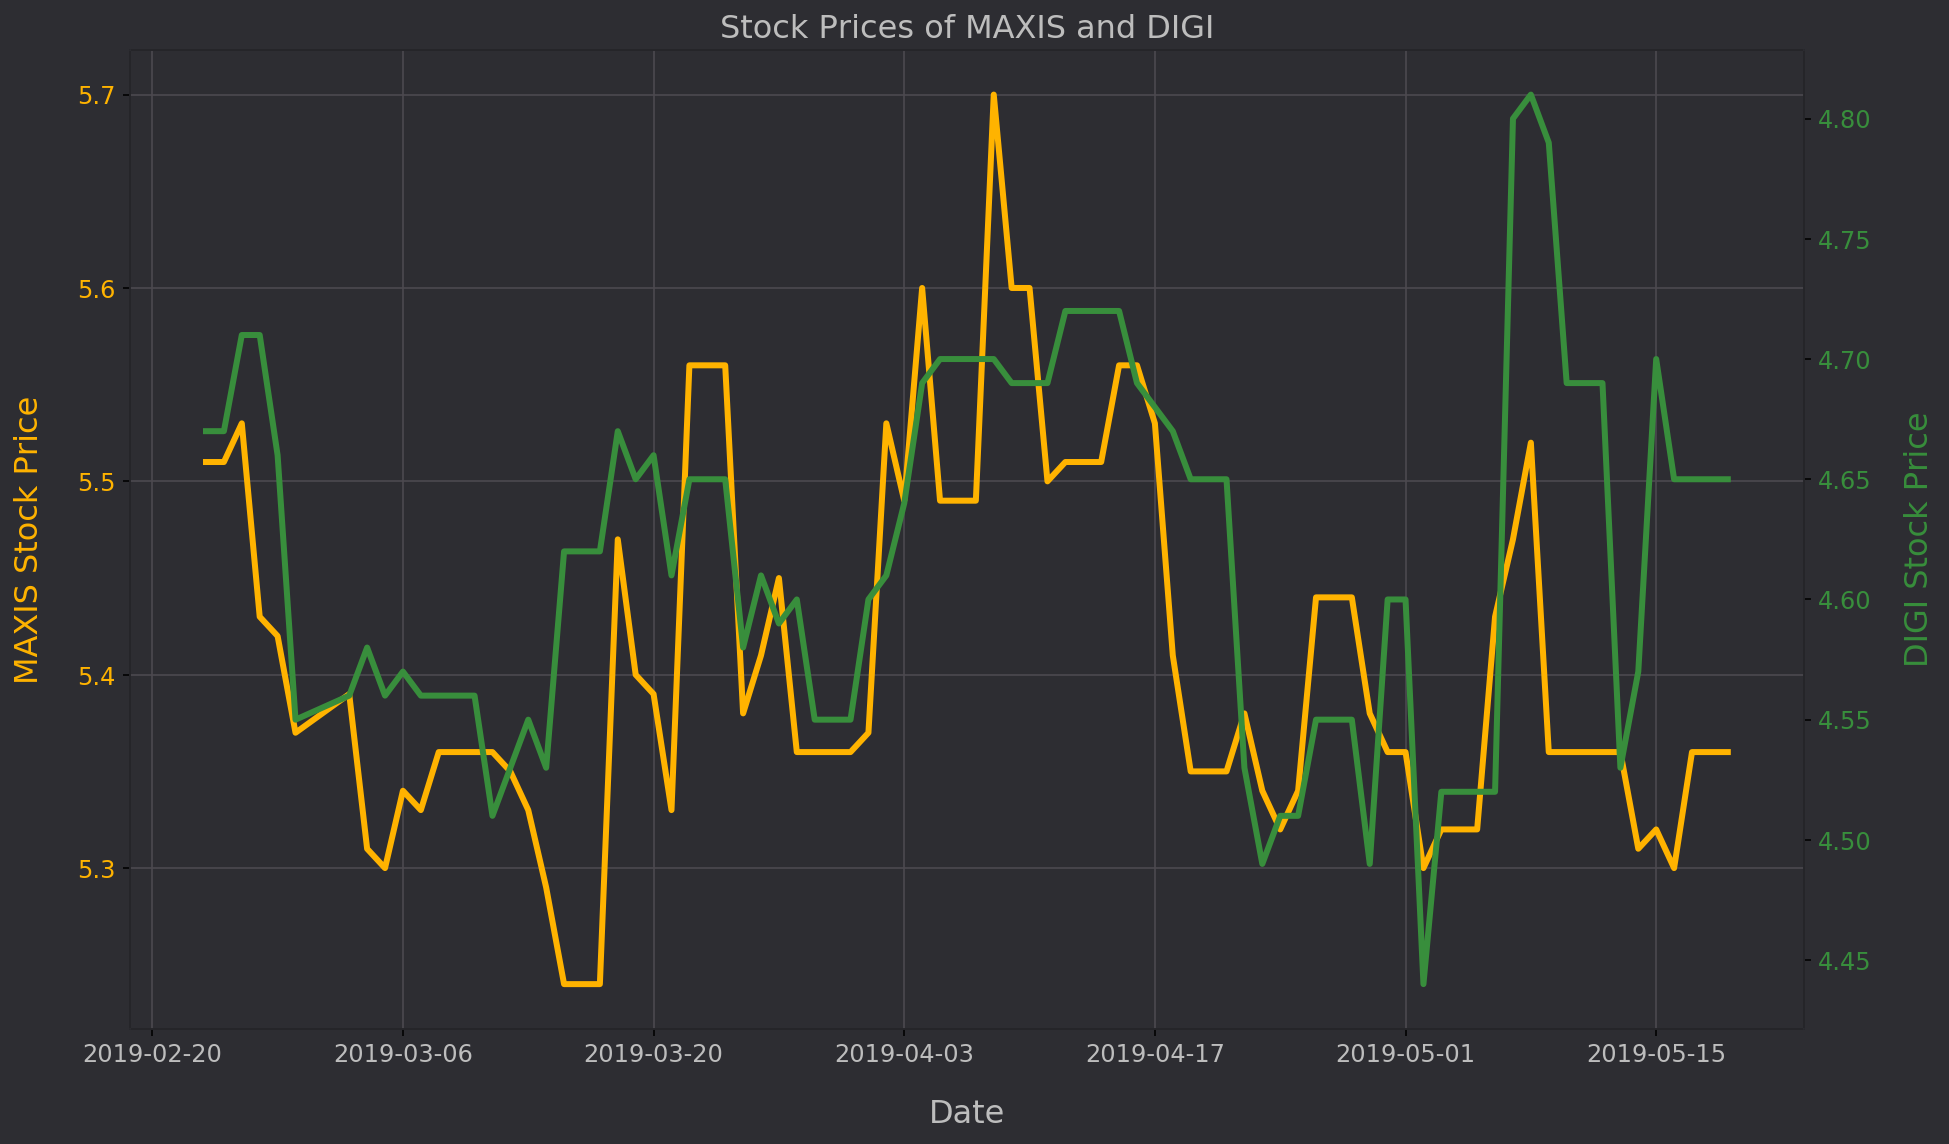

In [409]:
compare_stock_prices('MAXIS', 'DIGI')

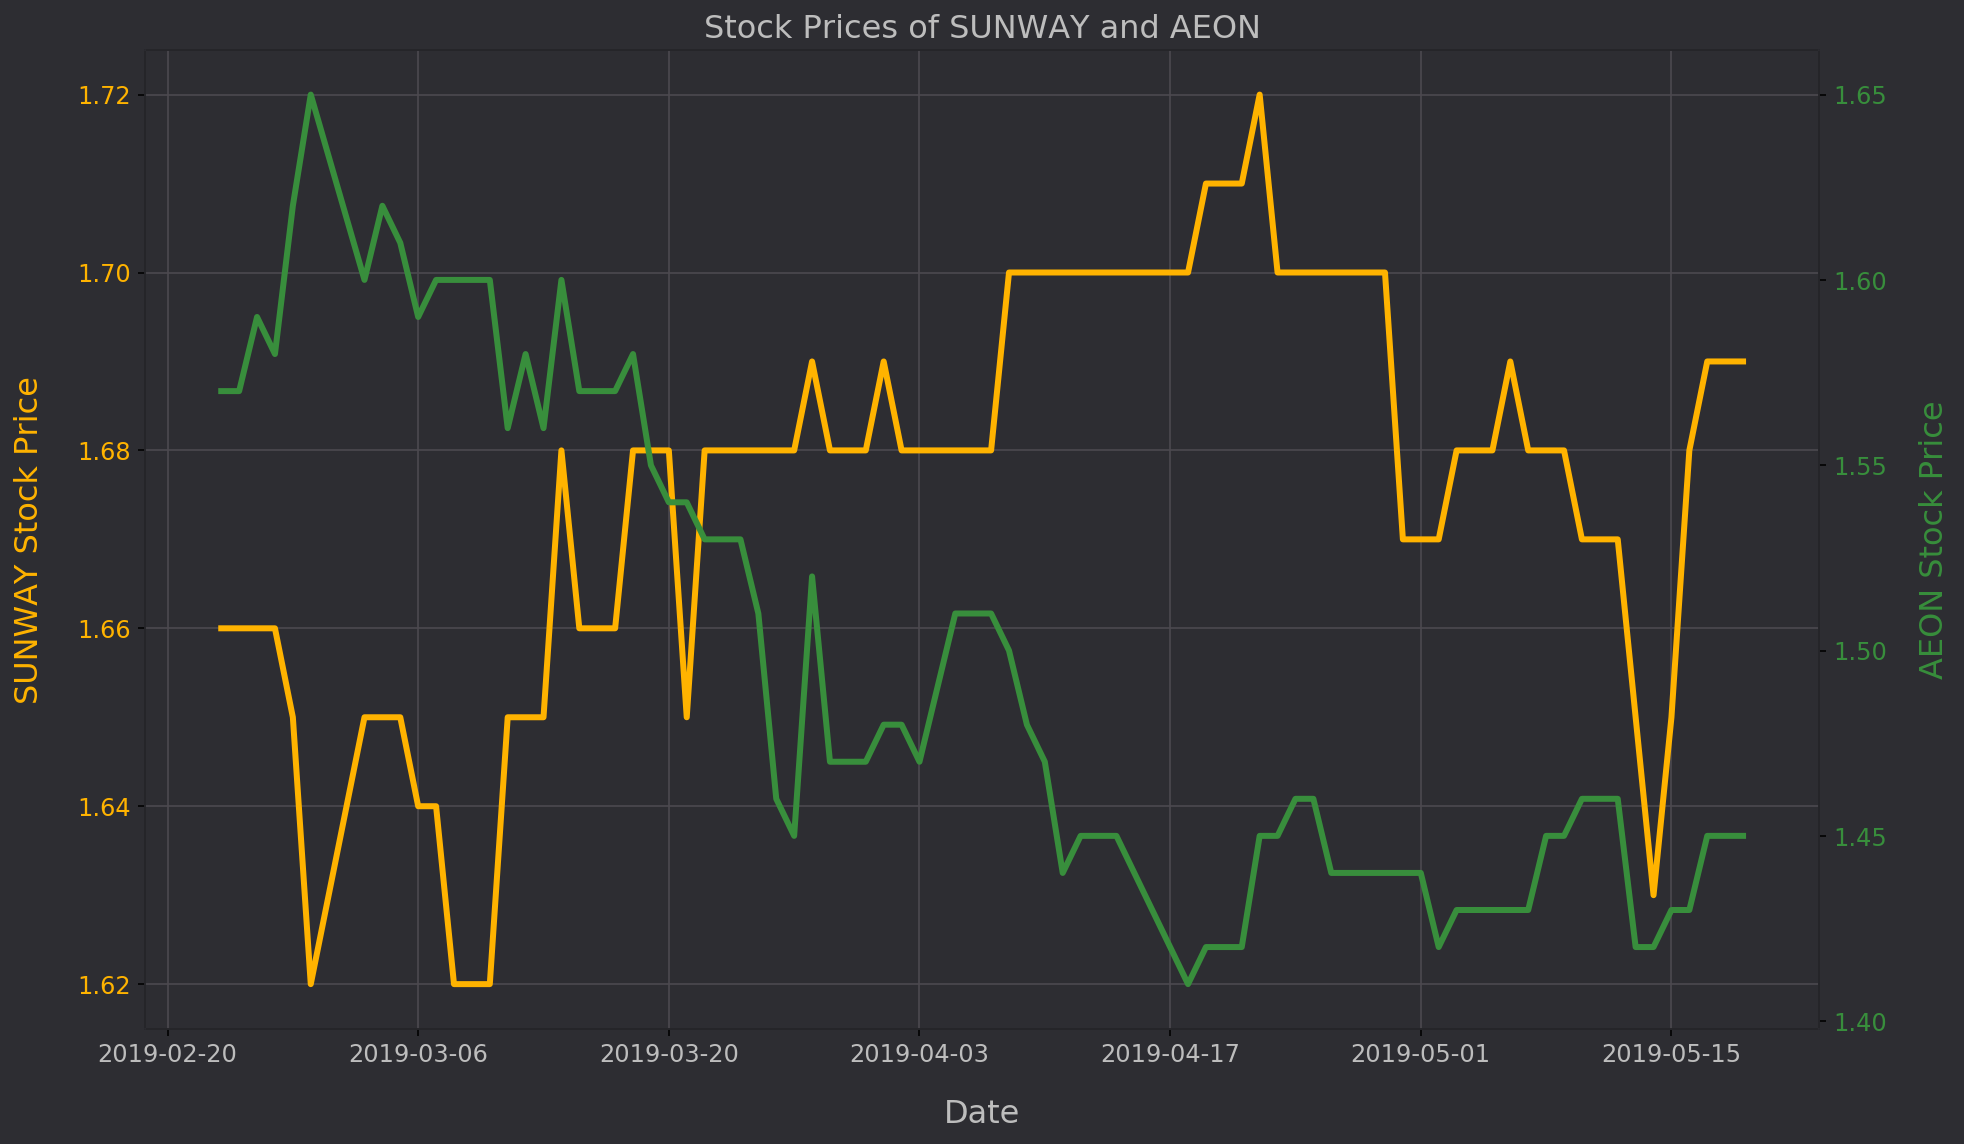

In [410]:
compare_stock_prices('SUNWAY', 'AEON')

## Companies with High Positive Correlation in Stock Price

In [411]:
com_last = pd.DataFrame()
for name, group in grouped:
    com_last[name] = group.last_price.values
corr = com_last.corr()
_comp_1 = []; _comp_2 = []; _corrs = []
for i in range(corr.shape[0]):
    print('.', end="")
    for j in range(corr.shape[1]):
        cr = corr.iat[i, j]
        if (cr > 0.7) and (i != j):
            _comp_1.append(corr.index[i])
            _comp_2.append(corr.columns[j])
            _corrs.append(cr)
significant_corr = pd.DataFrame({'Company 1': _comp_1, 
                                 'Company 2': _comp_2, 
                                 'Correlation': _corrs})
c12s = []
for i, r in significant_corr.iterrows():
    c12 = [r['Company 1'], r['Company 2']]
    c12s.append(' '.join(sorted(c12)))
significant_corr['c12'] = c12s
significant_corr.drop_duplicates(subset=['c12'], inplace=True)
significant_corr.drop('c12', axis=1, inplace=True)
significant_corr = (significant_corr
                    .sort_values('Correlation', ascending=False).head(20))
(significant_corr.style.set_table_styles(styles)
 .set_table_attributes('style="border-collapse: collapse"'))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,Company 1,Company 2,Correlation
89950,HIBISCS-CL,SUPERMX-C53,1
89953,HIBISCS-CL,UMW-C10,1
89954,HIBISCS-CL,UNISEM-C13,1
43995,DAIMAN,RHBBANK-C8,1
43996,DAIMAN,YINSON-CV,1
45993,DIALOG-C36,FBMKLCI-C5J,1
59687,FBMKLCI-C5J,HAPSENG-CX,1
185875,SIME-C27,SIMEPROP-CJ,1
137897,MHB-C13,SIME-C25,1
142917,MRCB-C32,TOPGLOV-C33,1


### Example

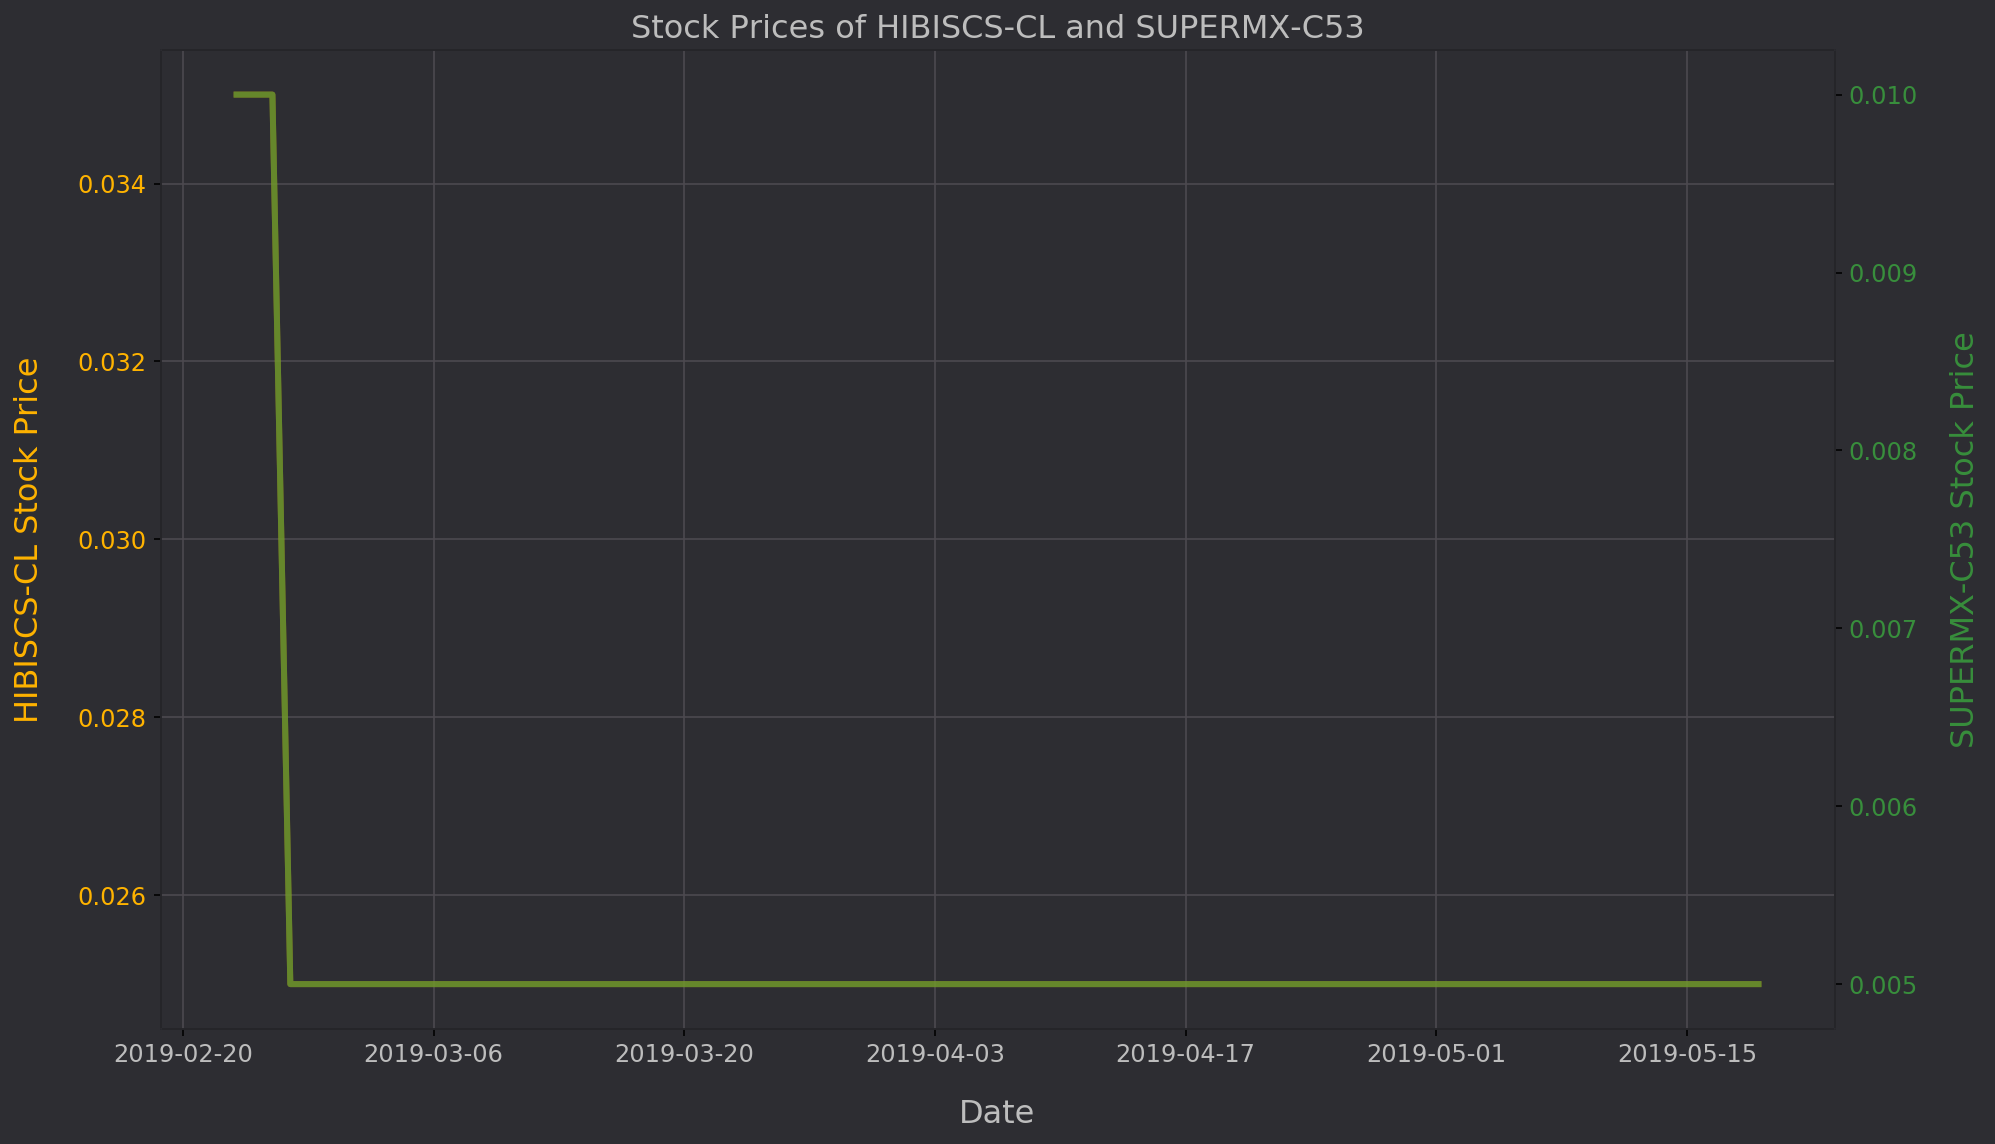

In [412]:
compare_stock_prices('HIBISCS-CL', 'SUPERMX-C53', alpha=0.6)

We now have a valuable table of companies whose stock prices change with each other.

## Companies with High Negative Correlation in Stock Price

In [413]:
_comp_1 = []; _comp_2 = []; _corrs = []
for i in range(corr.shape[0]):
    print('.', end="")
    for j in range(corr.shape[1]):
        cr = corr.iat[i, j]
        if (cr < -0.7) and (i != j):
            _comp_1.append(corr.index[i])
            _comp_2.append(corr.columns[j])
            _corrs.append(cr)
significant_corr = pd.DataFrame({'Company 1': _comp_1, 
                                 'Company 2': _comp_2, 
                                 'Correlation': _corrs})
c12s = []
for i, r in significant_corr.iterrows():
    c12 = [r['Company 1'], r['Company 2']]
    c12s.append(' '.join(sorted(c12)))
significant_corr['c12'] = c12s
significant_corr.drop_duplicates(subset=['c12'], inplace=True)
significant_corr.drop('c12', axis=1, inplace=True)
significant_corr = (significant_corr
                    .sort_values('Correlation', ascending=True).head(20))
(significant_corr.style.set_table_styles(styles)
 .set_table_attributes('style="border-collapse: collapse"'))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,Company 1,Company 2,Correlation
68070,MRCB-C32,YINSON-CV,-1
2796,AIRASIAC65,YINSON-CV,-1
84337,RHBBANK-C8,TOPGLOV-C33,-1
103176,TOPGLOV-C33,YINSON-CV,-1
2795,AIRASIAC65,RHBBANK-C8,-1
19811,DAIMAN,MRCB-C32,-1
39849,GTRONIC-CT,MISC-C21,-1
33272,FSBM,YFG,-1
33271,FSBM,XINQUAN-WA,-1
33270,FSBM,XINQUAN,-1


### Example

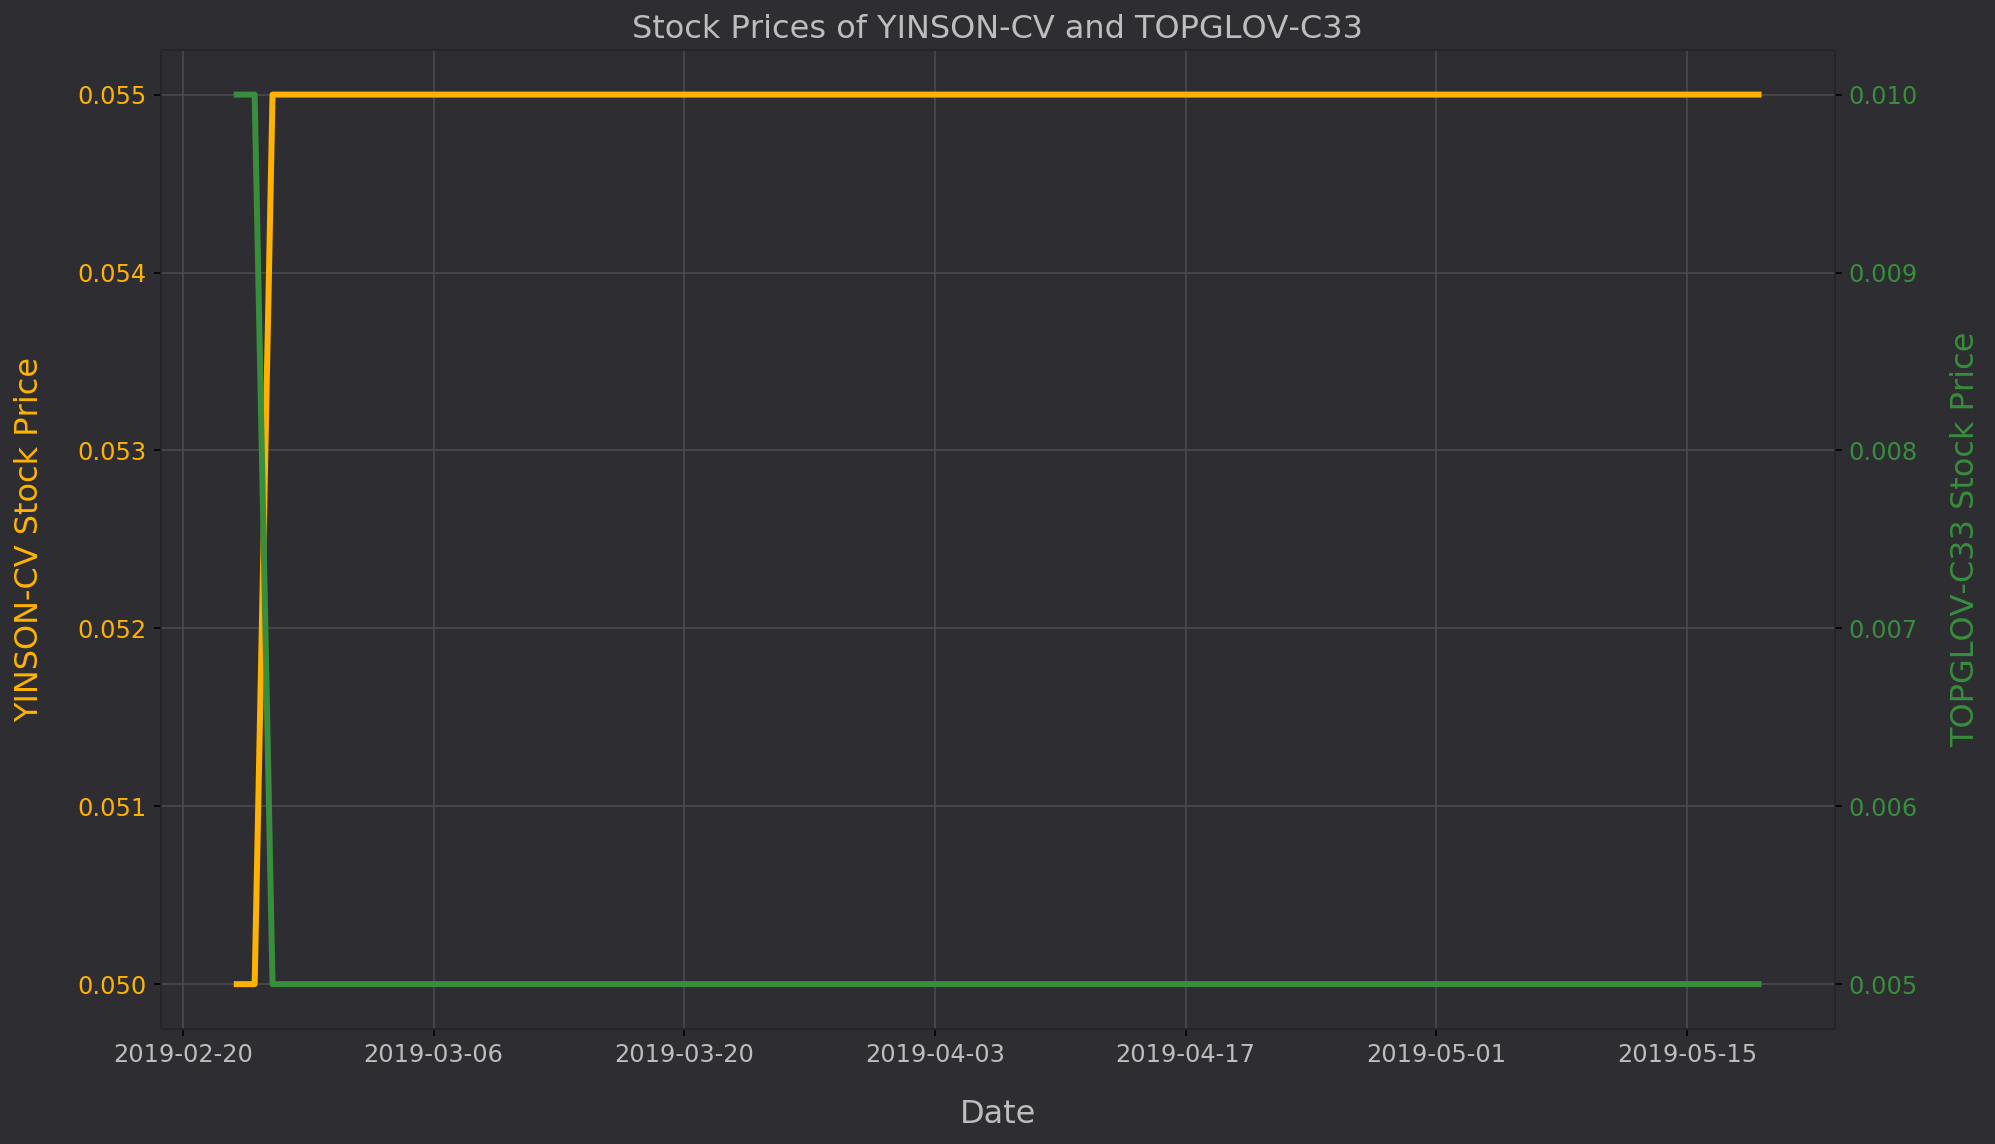

In [414]:
compare_stock_prices('YINSON-CV', 'TOPGLOV-C33')

## Open Price vs Last Price

In [415]:
def open_last(comp_sym):
    tg = grouped.get_group(comp_sym)
    tg.index = pd.to_datetime(tg.date)
    fig, ax1 = plt.subplots(figsize=(15, 9), facecolor=ax_facecolor);
    color='#00838f'
    ax1.plot(tg.last_price, color=color, linewidth=3);
    ax1.set_facecolor(ax_facecolor)
    ax1.set_title('Last and Open Stock Prices of ' + comp_sym, 
                  fontsize=16, color='#bdbdbd')
    ax1.set_xlabel("Date", labelpad=16, fontsize=16, color='#bdbdbd');
    ax1.tick_params(axis='x', labelcolor='#bdbdbd')
    ax1.set_ylabel("Last Price", color=color, labelpad=16, fontsize=16)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.grid(True, color='#4d4a50')
    ax2 = ax1.twinx()
    color='#f4511e'
    ax2.plot(tg.open_price, color=color, linewidth=3);
    ax2.set_ylabel("Open Price", color=color, labelpad=16, fontsize=16)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.spines['bottom'].set_color(ax_facecolor)
    ax2.spines['top'].set_color(ax_facecolor) 
    ax2.spines['right'].set_color(ax_facecolor)
    ax2.spines['left'].set_color(ax_facecolor)

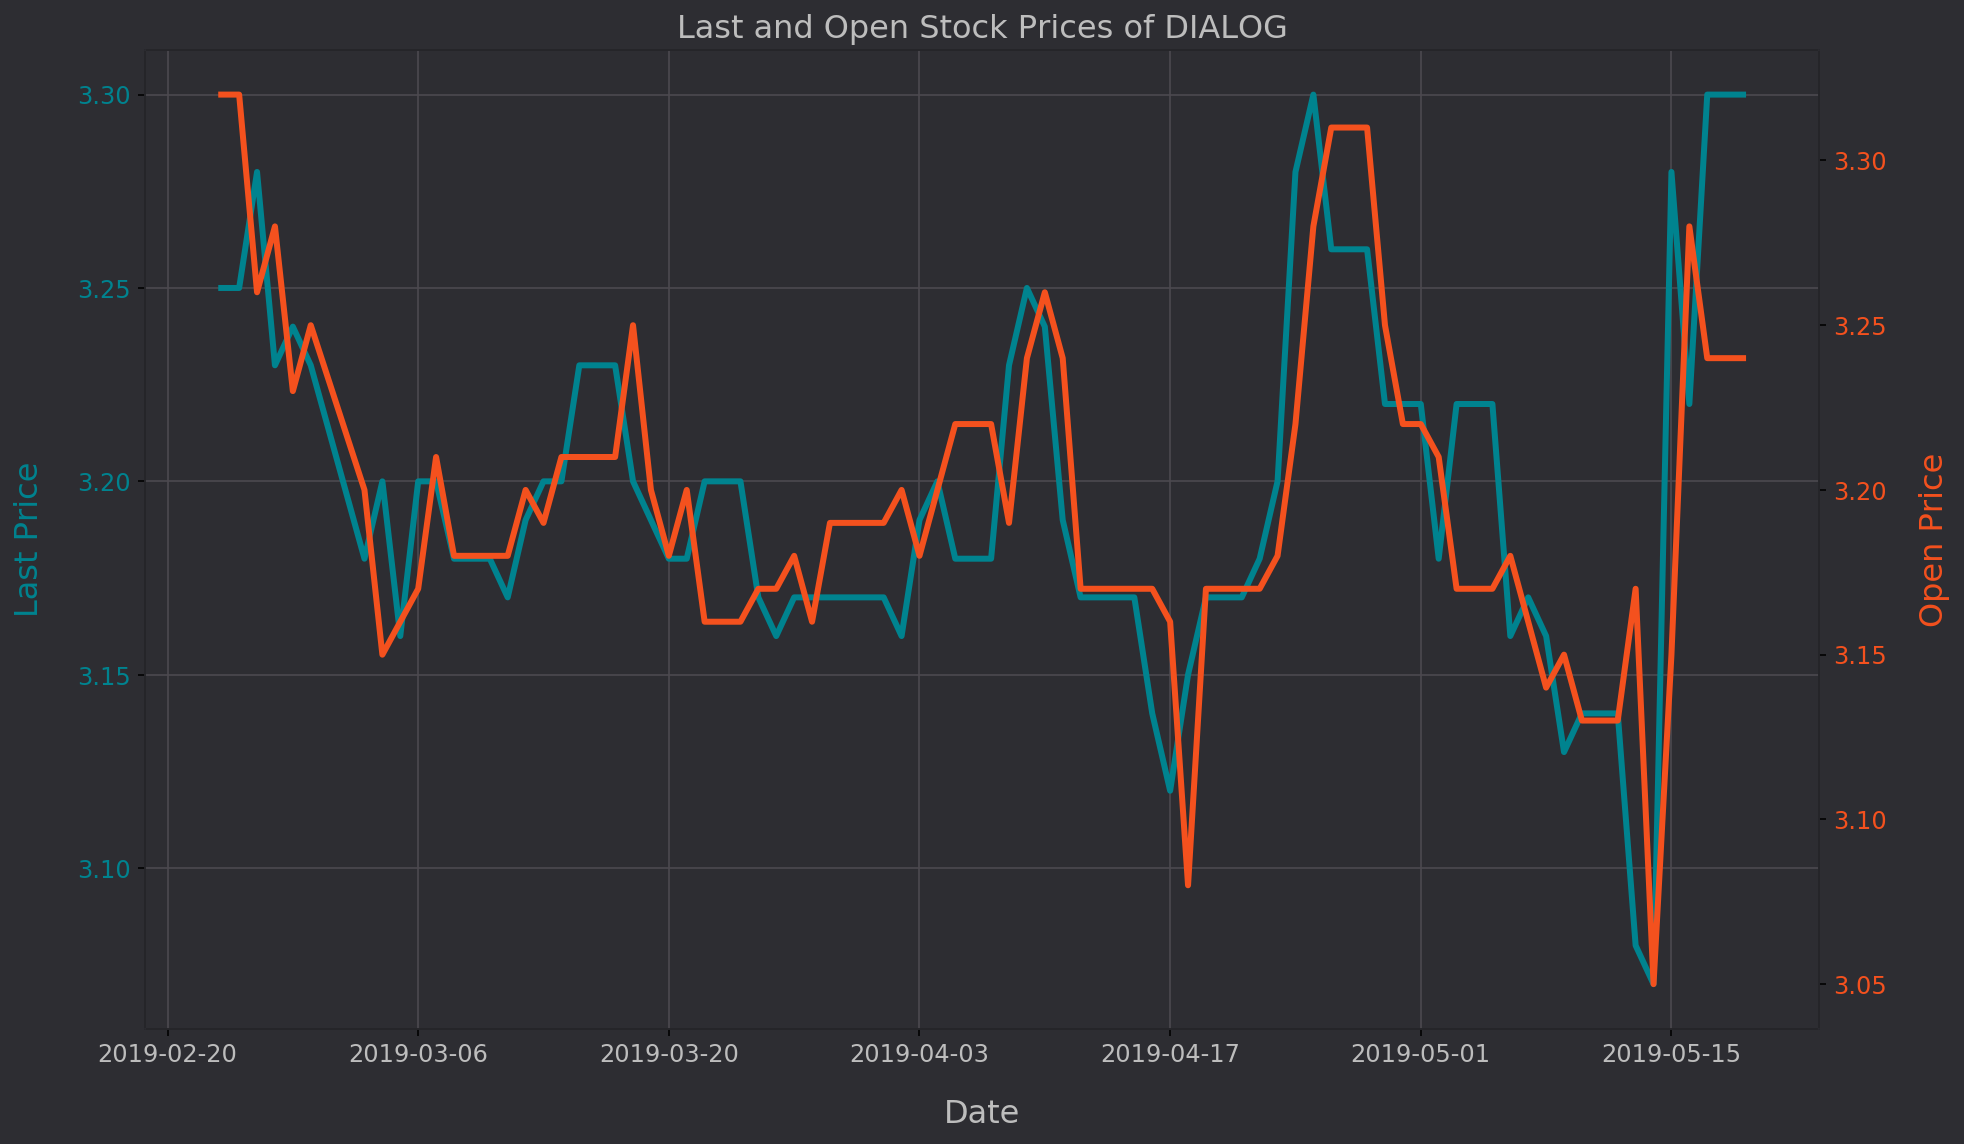

In [416]:
open_last('DIALOG')

## Clustering
Since our data is not labelled, we cannot apply supervised machine-learning techniques like regression and classification. But we can apply unsupervised techniques like clustering to discover similar groups of stocks.

### Feature Extraction From Time-Series Data

In [417]:
clust_df = pd.DataFrame(columns=['company', 'mean_last_price', 
                                 'std_last_price', 'last_minus_open',
                                 'minimum_last', 'maximum_last', 
                                 'last_price_skewness', 
                                 'last_argmax', 'last_argmin'])

for name, group in grouped:
    group = group.reset_index(drop=True)
    clust_df.loc[clust_df.shape[0], :] = \
        (name, group.last_price.mean(), group.last_price.std(),
         group.last_price.mean() - group.open_price.mean(),
         group.last_price.min(), group.last_price.max(),
         group.last_price.skew(), group.last_price.values.argmax(),
         group.last_price.values.argmin())
    

In [418]:
(clust_df.head().style.set_table_styles(styles)
 .set_table_attributes('style="border-collapse: collapse"'))

,company,mean_last_price,std_last_price,last_minus_open,minimum_last,maximum_last,last_price_skewness,last_argmax,last_argmin
0,3A,0.906667,0.0373145,0.00154618,0.84,0.98,-0.460247,29,6
1,A50CHIN-C22,0.0989286,0.0720194,-0.0804945,0.055,0.31,1.44093,7,28
2,A50CHIN-C24,0.79381,0.0686734,0.0242857,0.5,0.915,-2.40879,7,0
3,A50CHIN-C26,0.531607,0.0799592,0.0788799,0.38,0.615,-0.292595,42,0
4,A50CHIN-C28,0.260893,0.0717054,0.00582529,0.12,0.395,-0.22937,51,81


In [419]:
kmeans = (KMeans(n_clusters=3, random_state=2)
          .fit(clust_df[['mean_last_price', 'std_last_price']]))

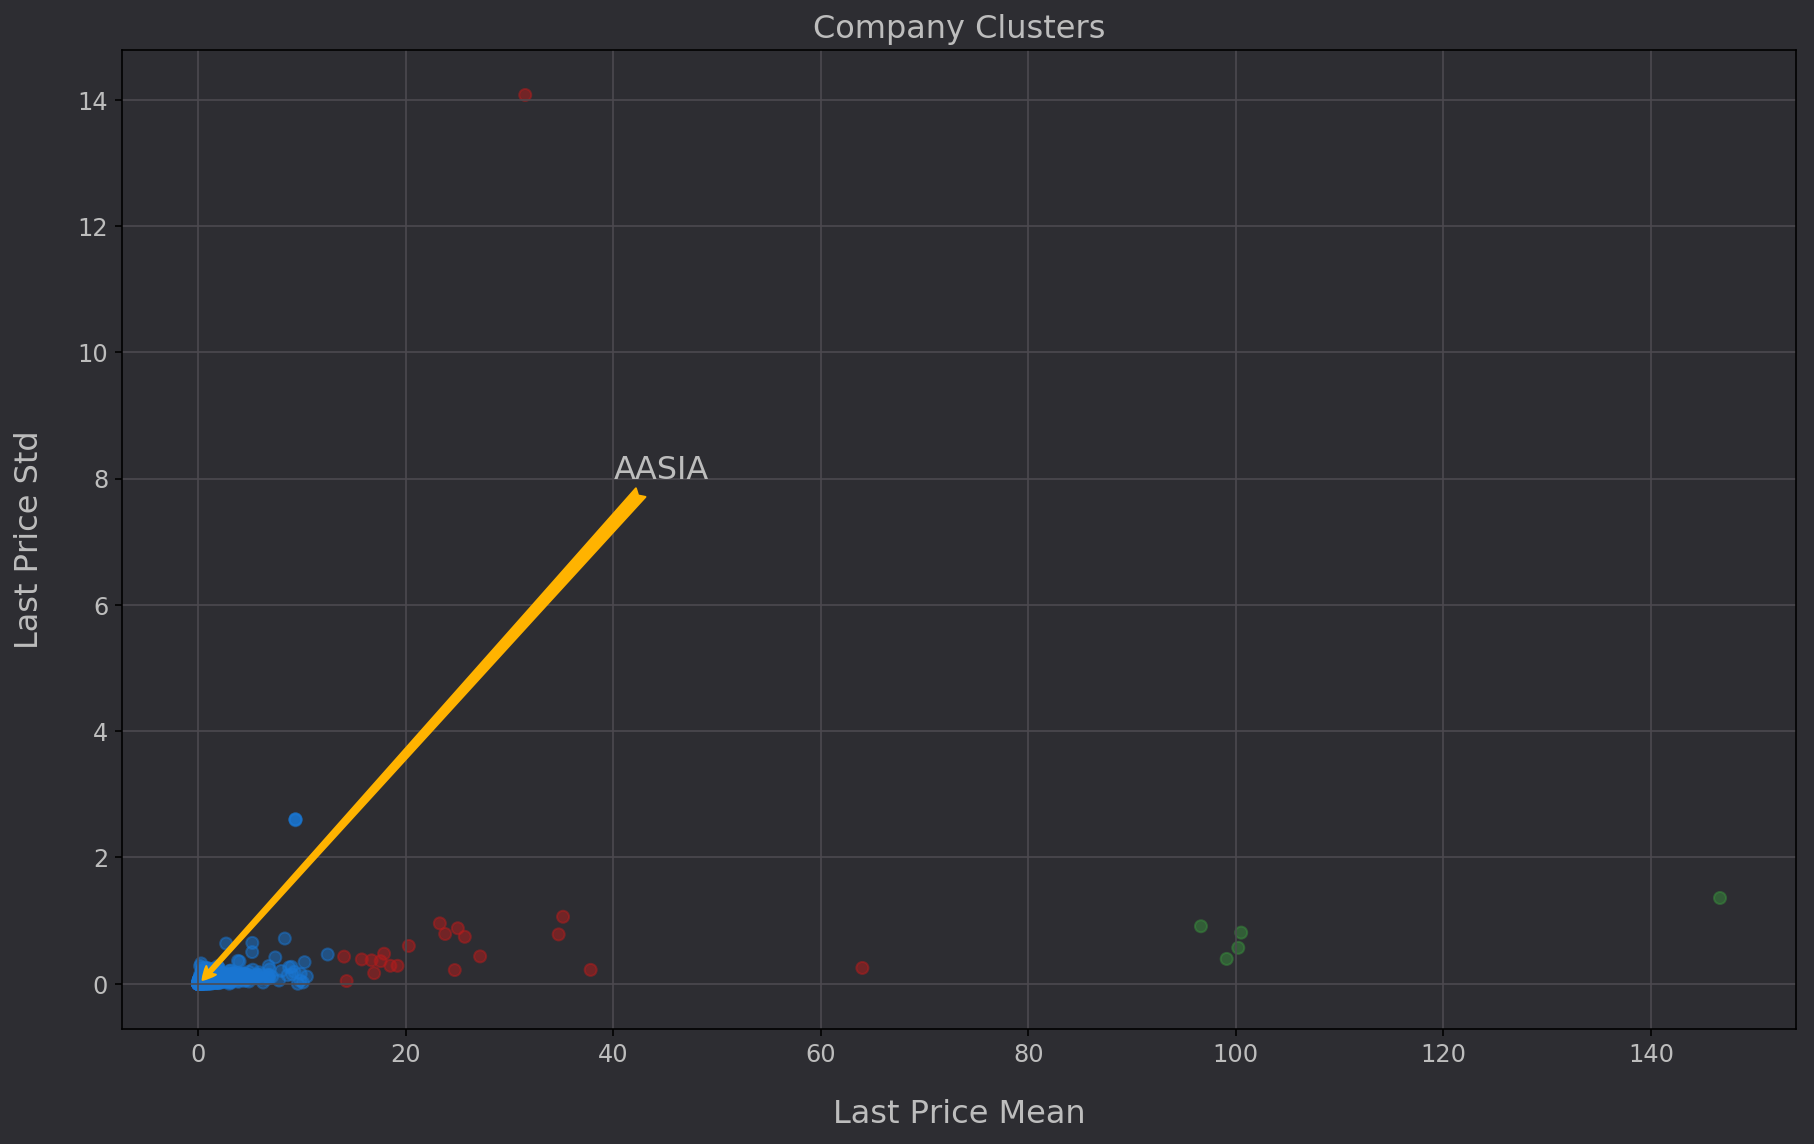

In [420]:
clust_colors = {0: '#1976d2', 1: '#388e3c', 2: '#b71c1c', 
                3: '#00838f', 4: '#f4511e'}
fig, ax1 = plt.subplots(figsize=(15, 9), facecolor=ax_facecolor);
color='#bdbdbd'
ax1.set_facecolor(ax_facecolor)
ax1.set_xlabel("Last Price Mean", labelpad=16, 
               fontsize=16, color='#bdbdbd');
ax1.tick_params(axis='x', labelcolor='#bdbdbd')
ax1.set_ylabel("Last Price Std", color=color, 
               labelpad=16, fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, color='#4d4a50')
ax1.scatter(clust_df.mean_last_price, clust_df.std_last_price, 
            c=pd.Series(kmeans.labels_).map(clust_colors), alpha=0.5);
ax1.set_title('Company Clusters', fontsize=16, color='#bdbdbd')
plt.annotate('AASIA', 
             (clust_df.loc[clust_df.company == 'AASIA', 'mean_last_price'], 
              clust_df.loc[clust_df.company == 'AASIA', 'std_last_price']), 
             xytext=(40, 8), color='#bdbdbd', fontsize=16,
             arrowprops={'arrowstyle': 'fancy', 'color': '#ffb300'});

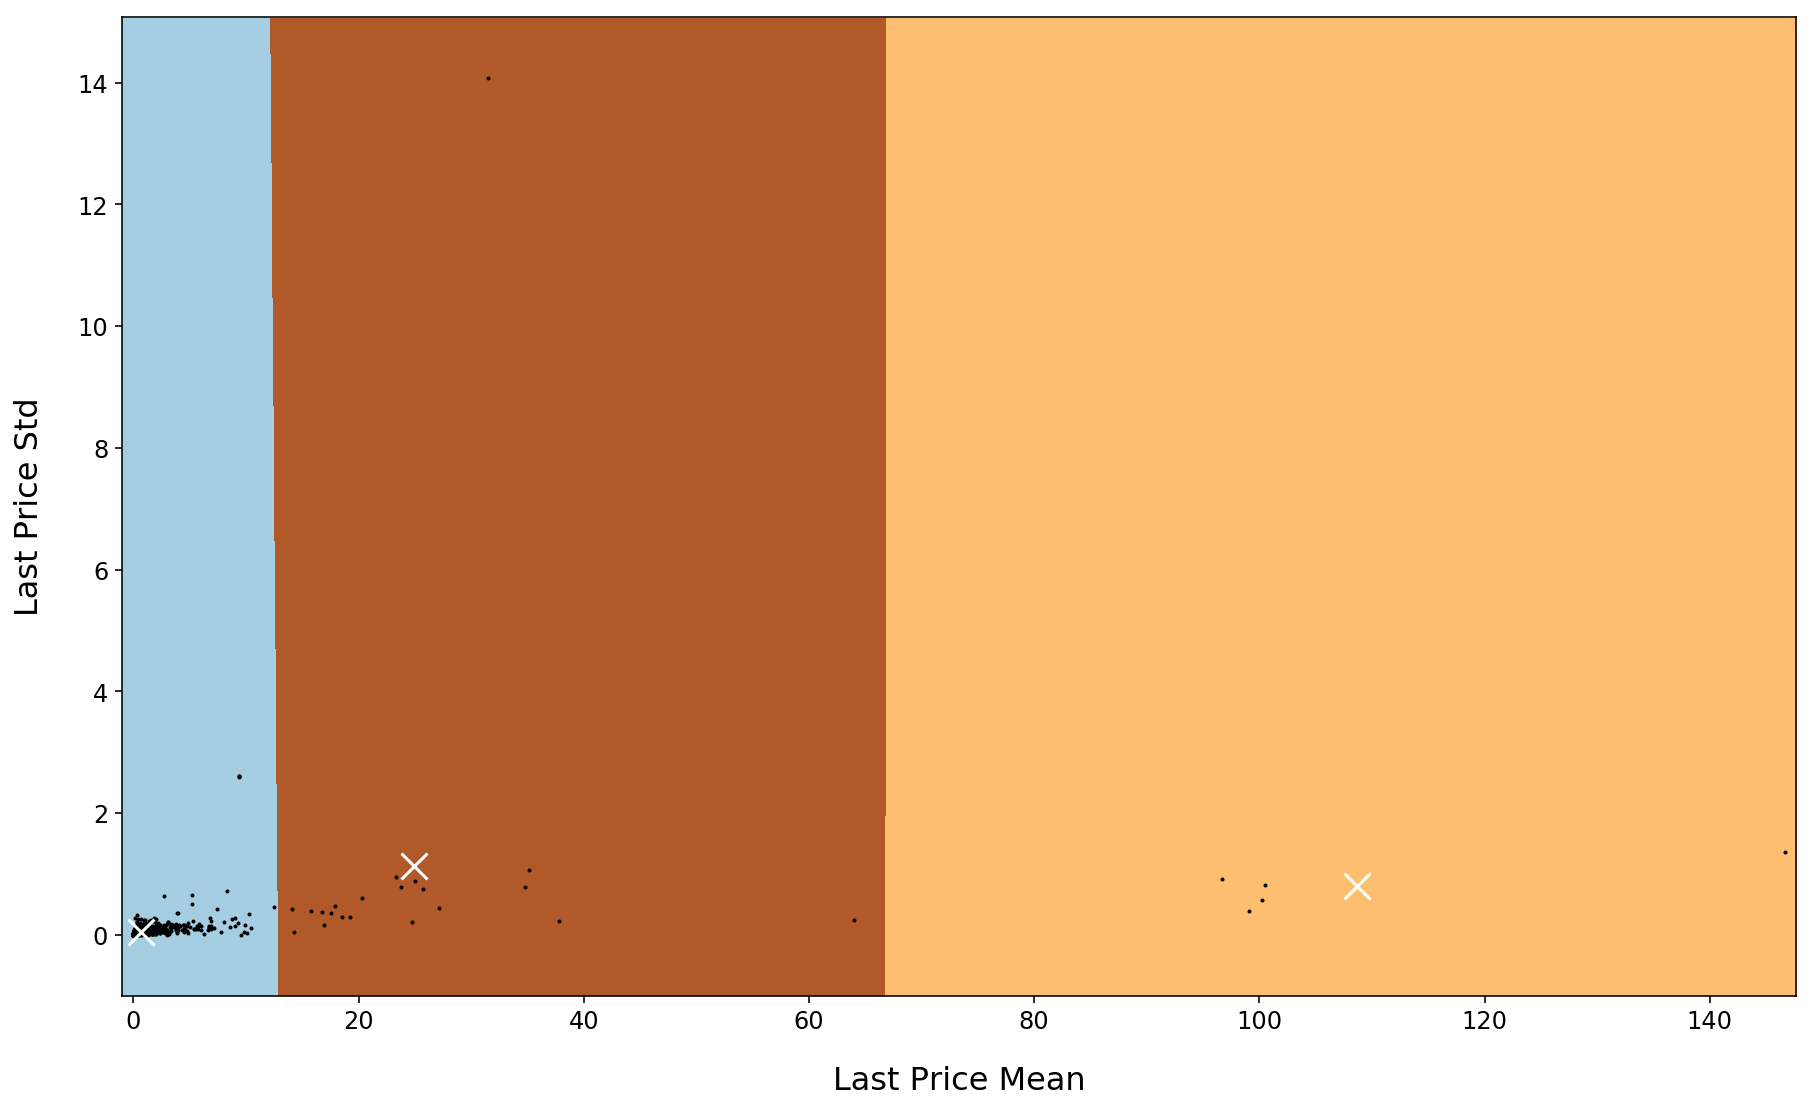

In [421]:
reduced_data = clust_df[['mean_last_price', 'std_last_price']].values
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)
h = .02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15,9))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Last Price Mean", labelpad=16, fontsize=16);
plt.ylabel("Last Price Std", labelpad=16, fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

## Stock Market Structure Visualization and Clustering

We want to extract the stock market structure from variations in historical stocks. The quantity that we use is the daily variation in stock price: stocks that are linked tend to cofluctuate during a day.

We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others.

We use clustering to group together stocks that behave similarly. Here, amongst the various clustering techniques available in the scikit-learn, we use Affinity Propagation as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use Manifold learning techniques to retrieve 2D embedding.

The output of the 3 models are combined in a 2D graph where nodes represents the stocks and edges the:

* cluster labels are used to define the color of the nodes
* the sparse covariance model is used to display the strength of the edges
* the 2D embedding is used to position the nodes in the plan

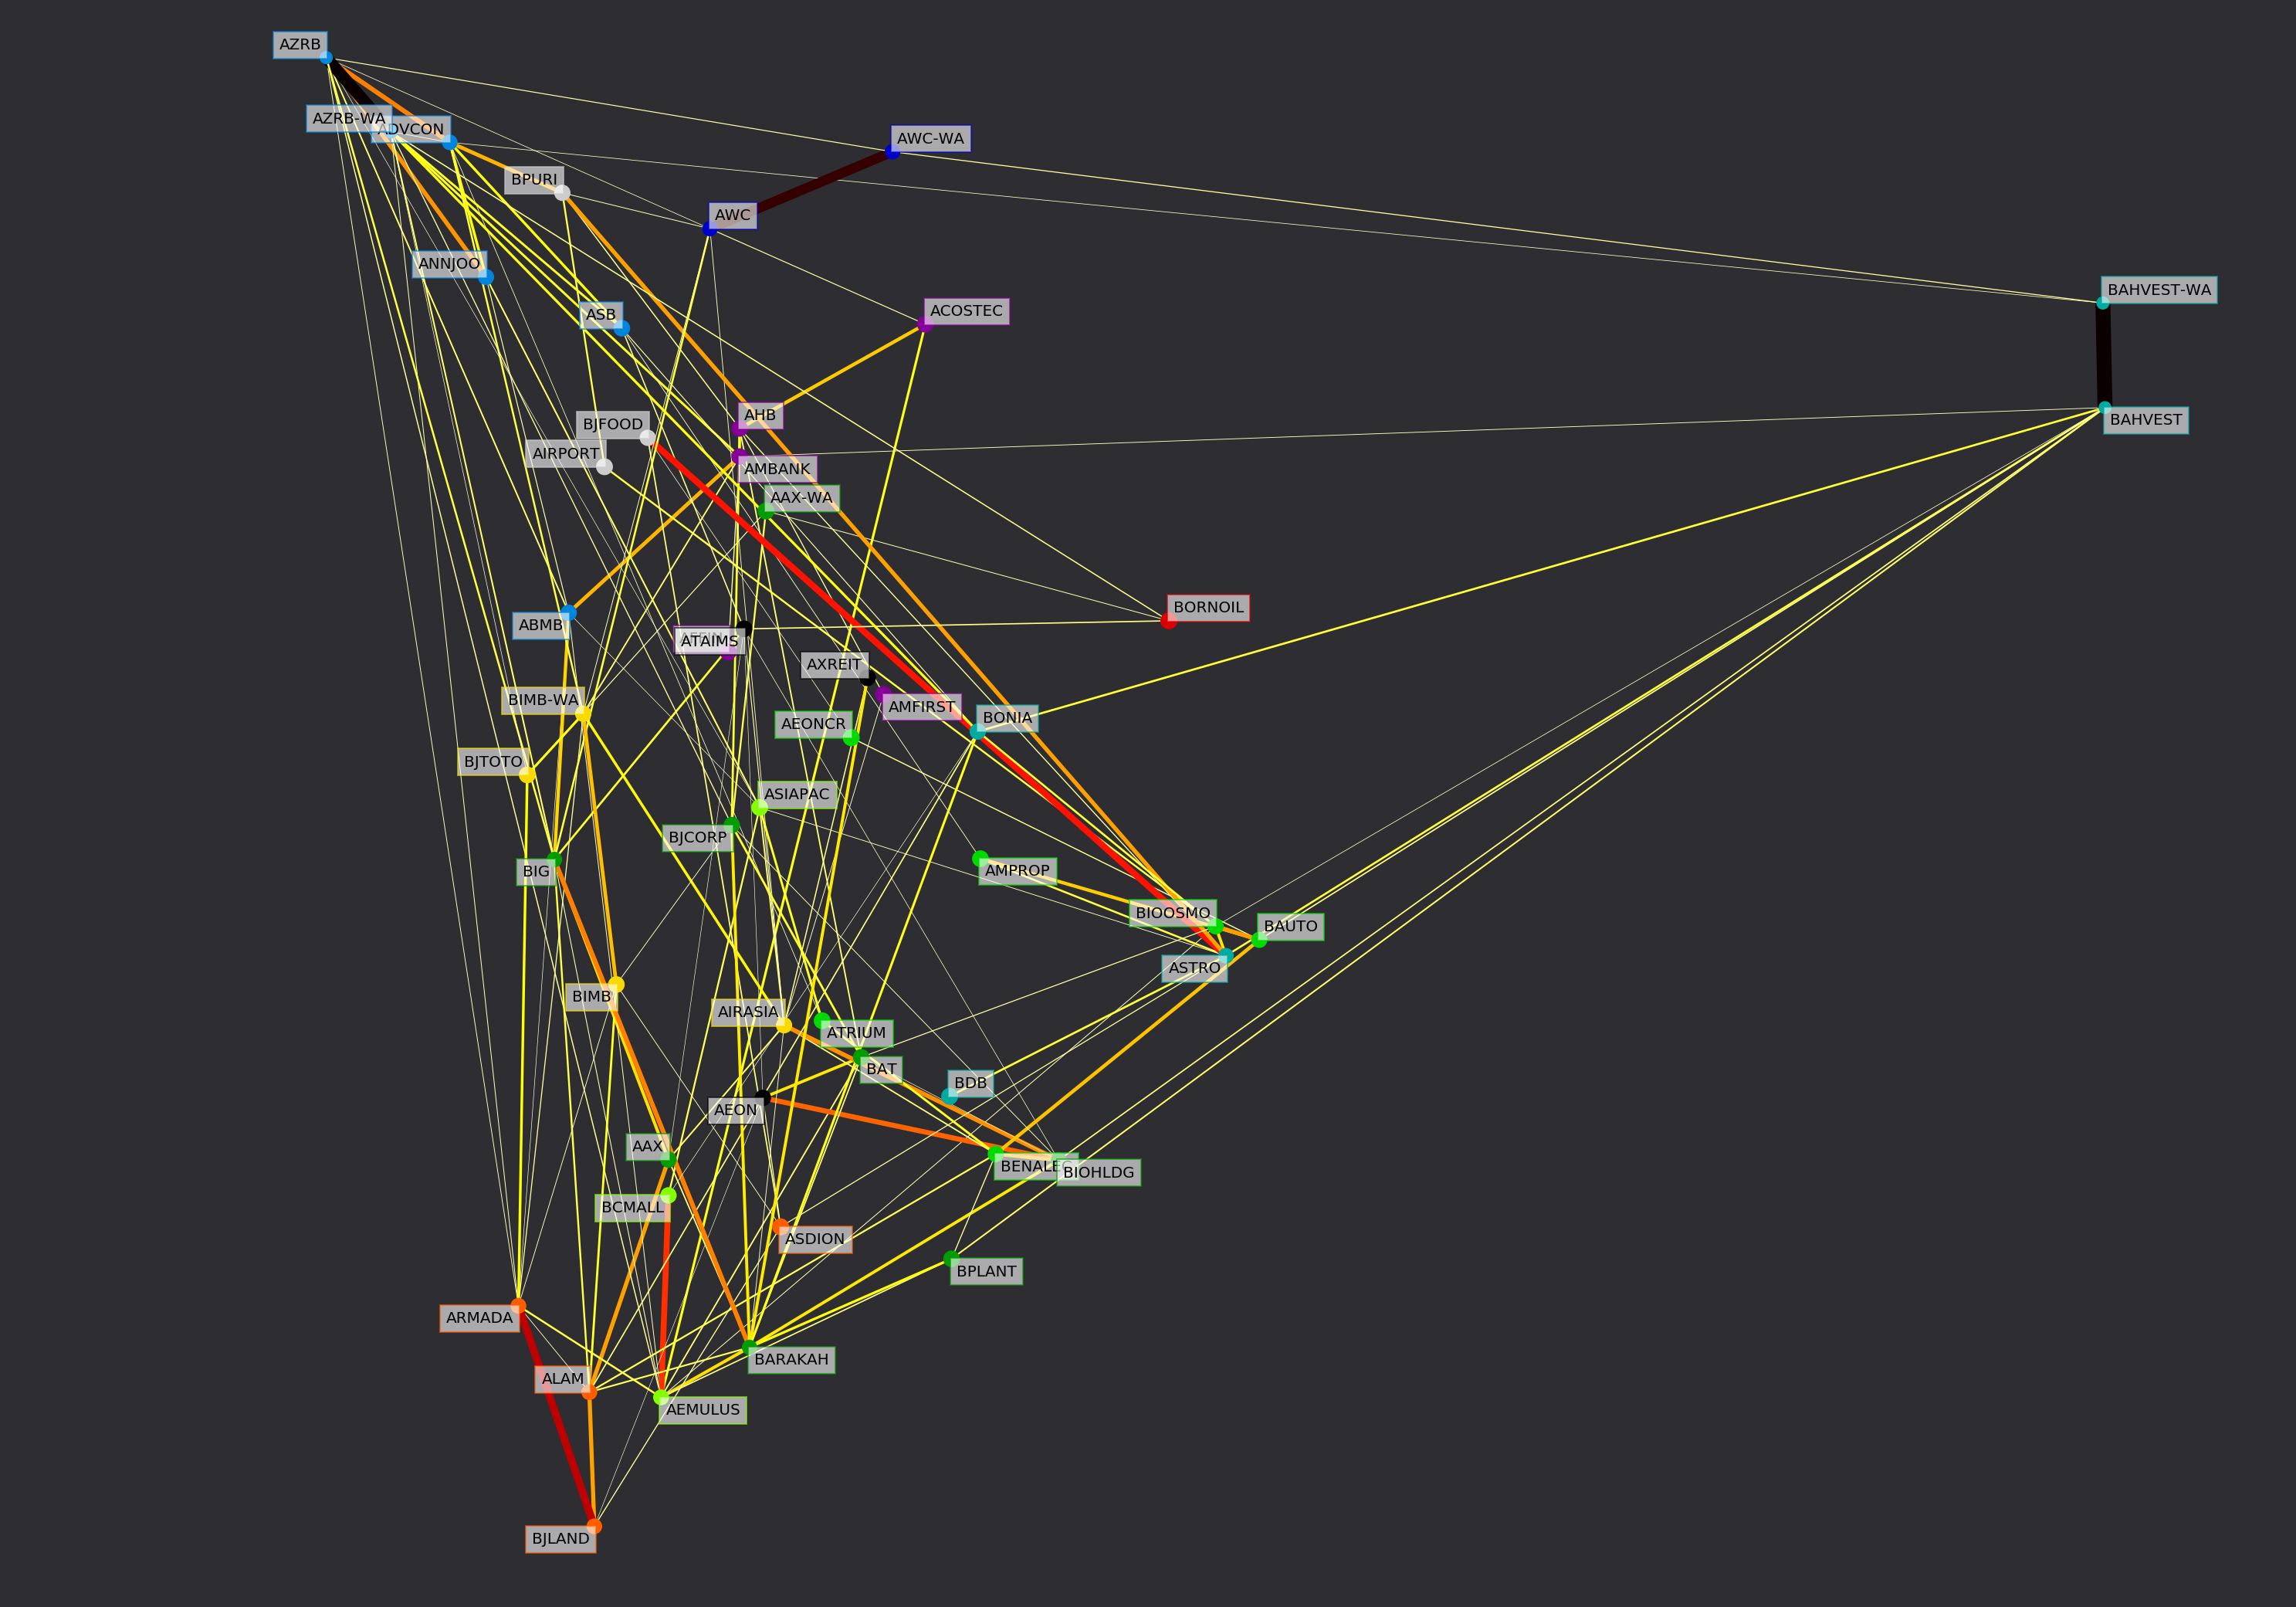

In [422]:
edge_model_cv = 5
company_limit = 55
manifold_n_neighbors = 6
# %matplotlib notebook
%matplotlib inline

symbols = []
names = []
quotes = []
i = 0
companies_complete_open_prices = []
for name, group in grouped:
    if group['open_price'].isna().sum() > 0:
        continue
    companies_complete_open_prices.append(name)

np.random.seed(10)
chosen_companies = np.random.choice(companies_complete_open_prices, 55)
chosen_companies = companies_complete_open_prices[:50]

for name in chosen_companies:
    symbols.append(name)
    names.append(name)
    group = grouped.get_group(name)
    group = (group[['date', 'open_price', 'last_price']]
             .reset_index(drop=True))
    group = group.rename(columns={'open_price': 'open', 
                                  'last_price': 'close'})
    quotes.append(group)
    i += 1
    if i == company_limit:
        break

symbols = np.array(symbols)
names = np.array(names)

close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

variation = close_prices - open_prices

edge_model = covariance.GraphicalLassoCV(cv=edge_model_cv)

X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

display(HTML("<h3>Clusters:</h3>"))
for i in range(n_labels + 1):
    display(HTML("<p>" + 
                 'Cluster %i: %s' % ((i + 1), ', '.join(
                     names[labels == i])) + "</p>"))

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', 
    n_neighbors=manifold_n_neighbors)

embedding = node_position_model.fit_transform(X.T).T

# Visualization
fig, ax = plt.subplots(figsize=(20, 14), facecolor=ax_facecolor)
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(
                           label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

fig.savefig('stock_structure_vis.png', format='png', 
            dpi=300, facecolor=ax_facecolor)
os.system('open stock_structure_vis.png');

# source: https://scikit-learn.org/

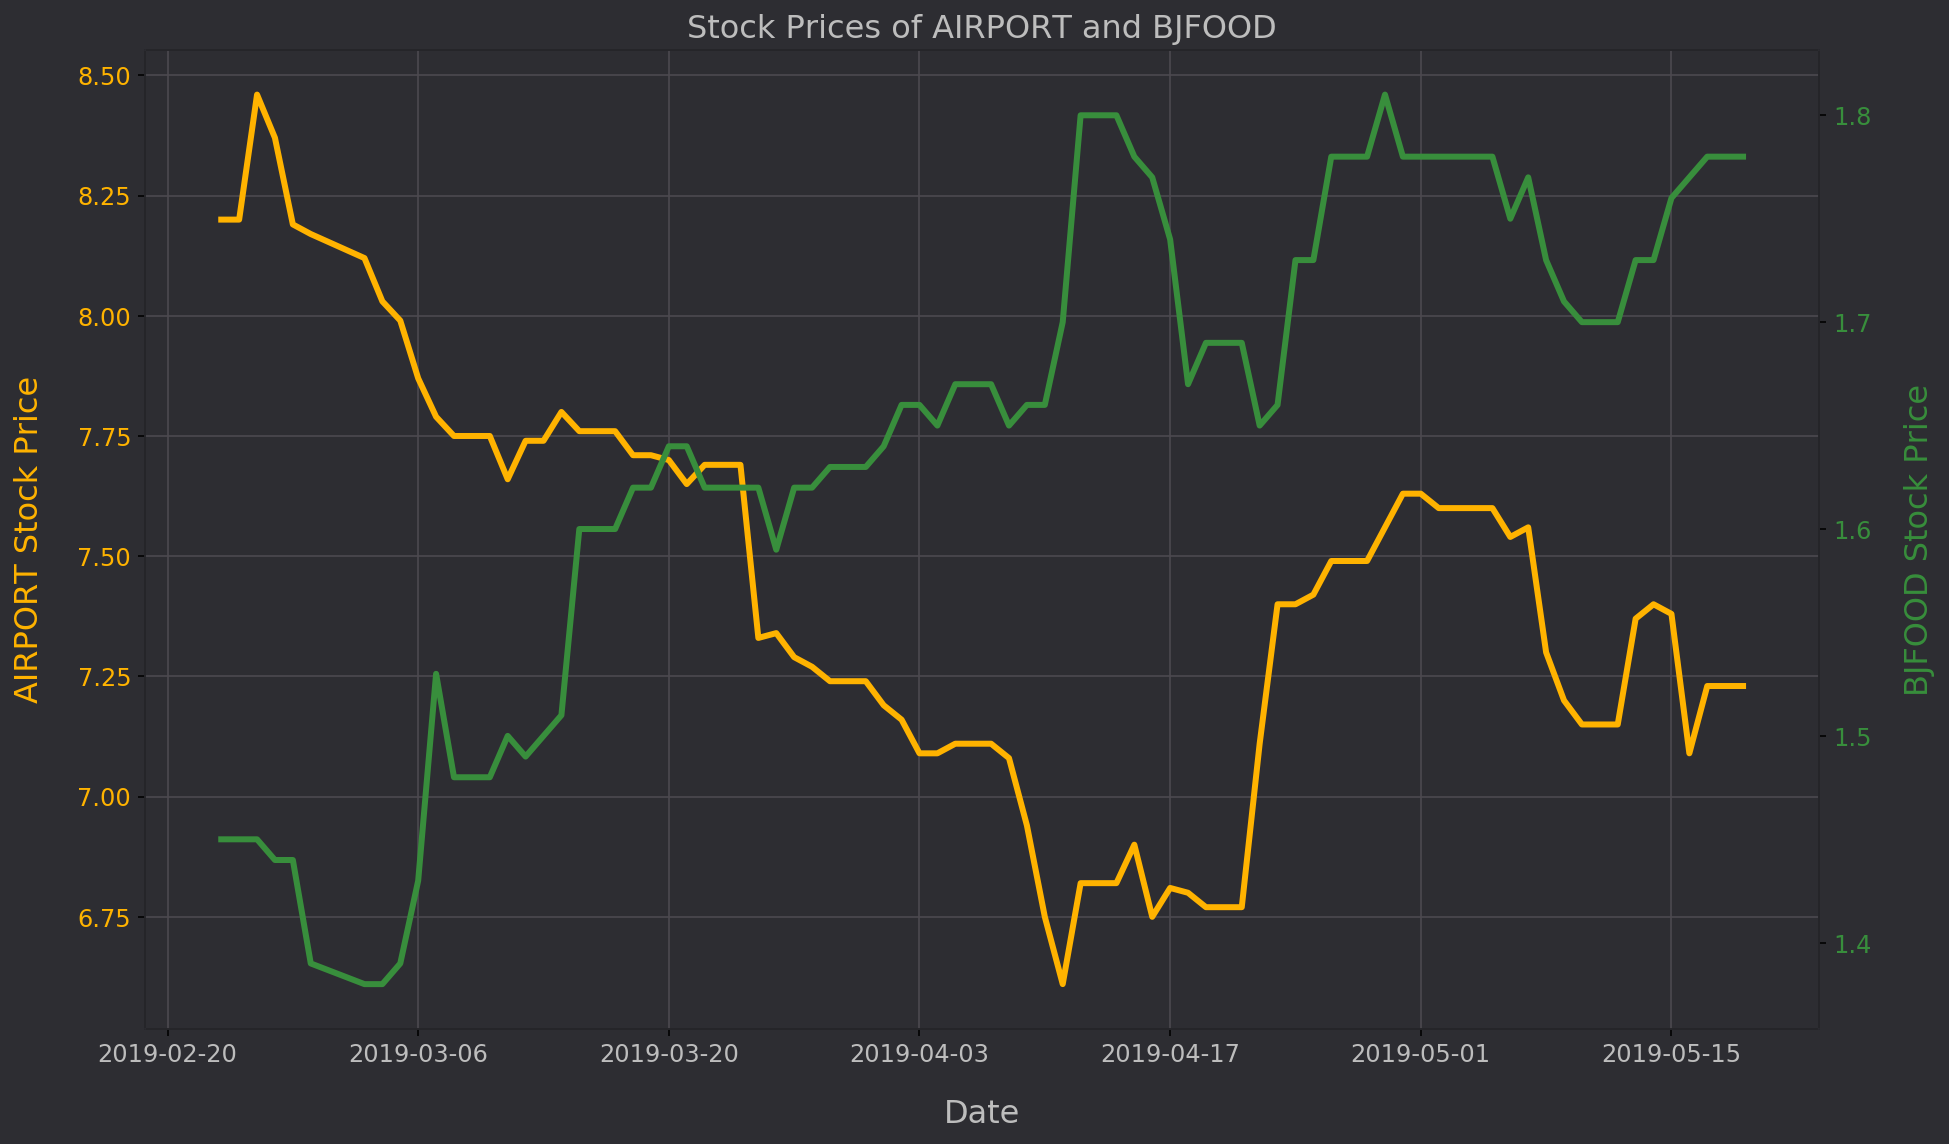

In [423]:
compare_stock_prices('AIRPORT', 'BJFOOD')

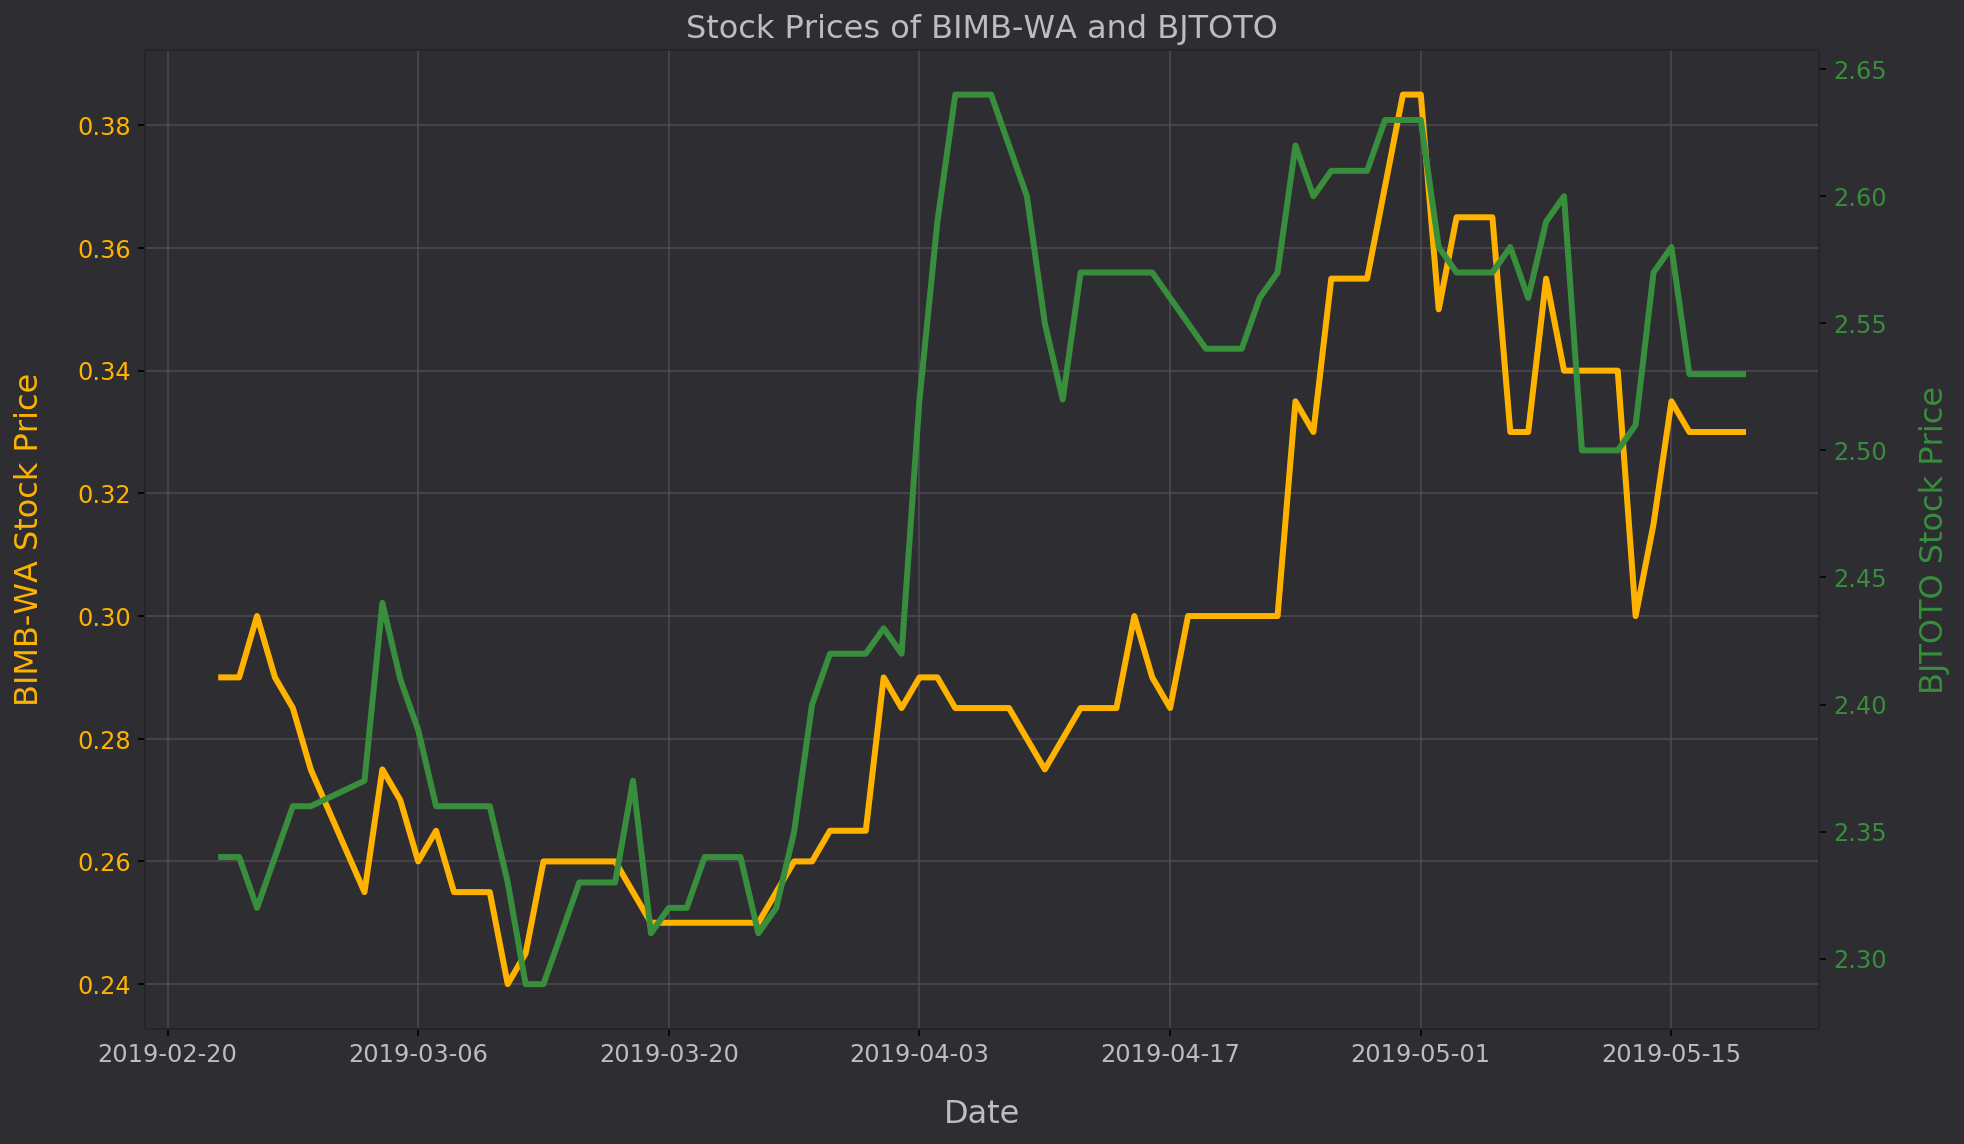

In [424]:
compare_stock_prices('BIMB-WA', 'BJTOTO')

## Recommendation
We will recommend to the user the stocks that have low price now and that are expected to have higher price in the future. And assuming that the user wants Shariah-compliant stocks, we will take that into consideration.

### The Compny-Info Table

In [425]:
company_info = pd.read_csv('Data/company_info.csv')
def clean_ci_data(item):
    if isinstance(item, str):
        return item.strip()
company_info = company_info.applymap(func=clean_ci_data)
(company_info.head().style.set_table_styles(styles)
 .set_table_attributes('style="border-collapse: collapse"'))

,company_full_name,company_symbol,last_quarter,last_quarter_revenue_000,last_quarter_net_profit_000,board,shariah_compliant,sector,sub_sector,market_capital,num_of_share,roe
0,ASTRAL ASIA BERHAD,AASIA,31 Dec 2018,"2,673",692,MAIN,Compliant,Plantation,Plantation,102.30m,659.98m,-2.70
1,AIRASIA X BERHAD,AAX,31 Mar 2019,"1,168,804","43,333",MAIN,Compliant,Consumer Products & Services,"Travel, Leisure & Hospitality",933.33m,4.148b,-39.42
2,ABF MALAYSIA BOND INDEX FUND,ABFMY1,30 Sep 2018,"28,446",0,ETF,Non-Compliant,Exchange Traded Fund-bond,Bond Fund,1.501b,1.265b,-
3,ABLEGROUP BERHAD,ABLEGRP,31 Dec 2018,"1,413",-70,MAIN,Compliant,Industrial Products & Services,Building Materials,18.47m,263.90m,-2.18
4,ALLIANCE BANK MALAYSIA BERHAD,ABMB,31 Dec 2018,"418,401","148,932",MAIN,Non-Compliant,Financial Services,Banking,5.821b,1.548b,9.67


In [426]:
stocks_of_interest = []
for name, group in grouped:
    g_last_price = group.last_price.reset_index(drop=True)
    # first part is from the beginning until 10 days before now
    part_1 = g_last_price.iloc[:-10]
    # second part is from 10 days ago until 2 days ago
    part_2 = g_last_price.iloc[-10:-2]
    # third part is the last two days
    part_3 = g_last_price.iloc[-2:]
    if ( np.mean(part_1) > 1.5 * np.mean(part_2) ) and \
        ( np.mean(part_3) > np.mean(part_2) ):
        stocks_of_interest.append(name)

In [427]:
len(stocks_of_interest)

25

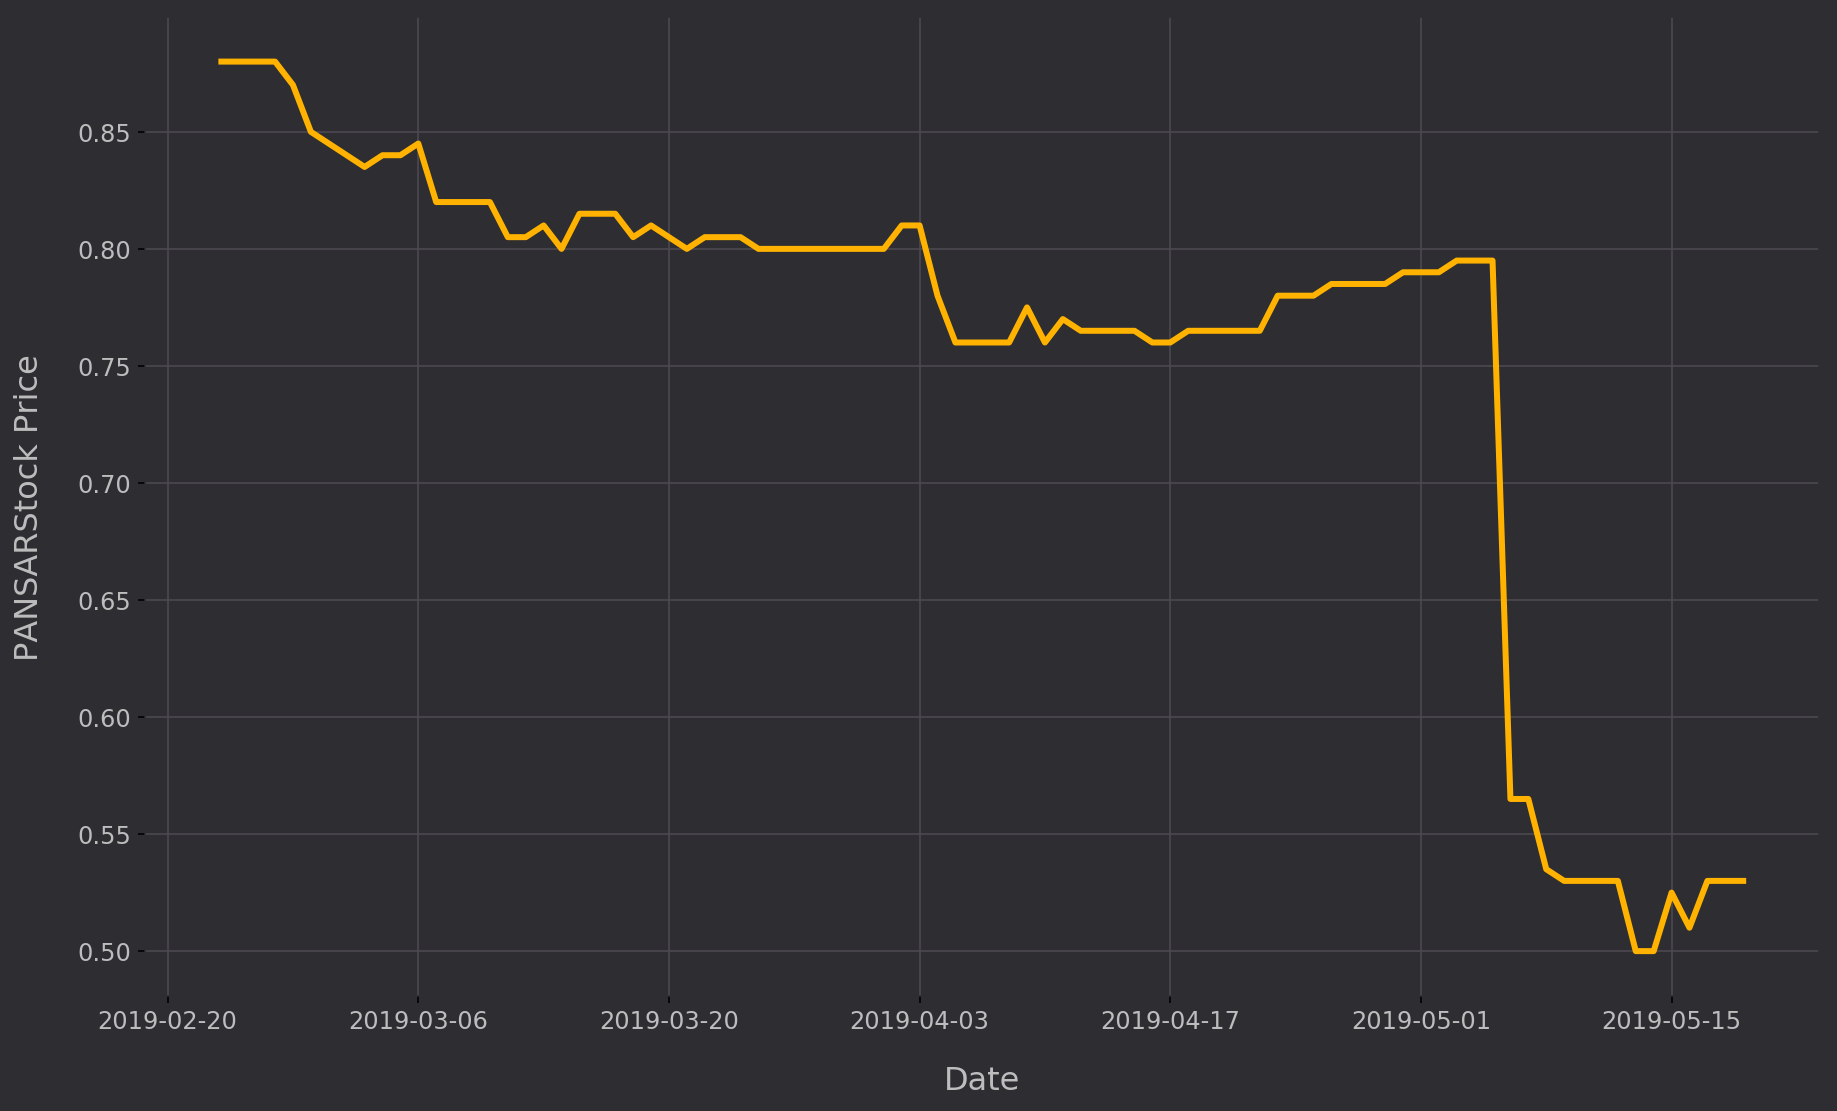

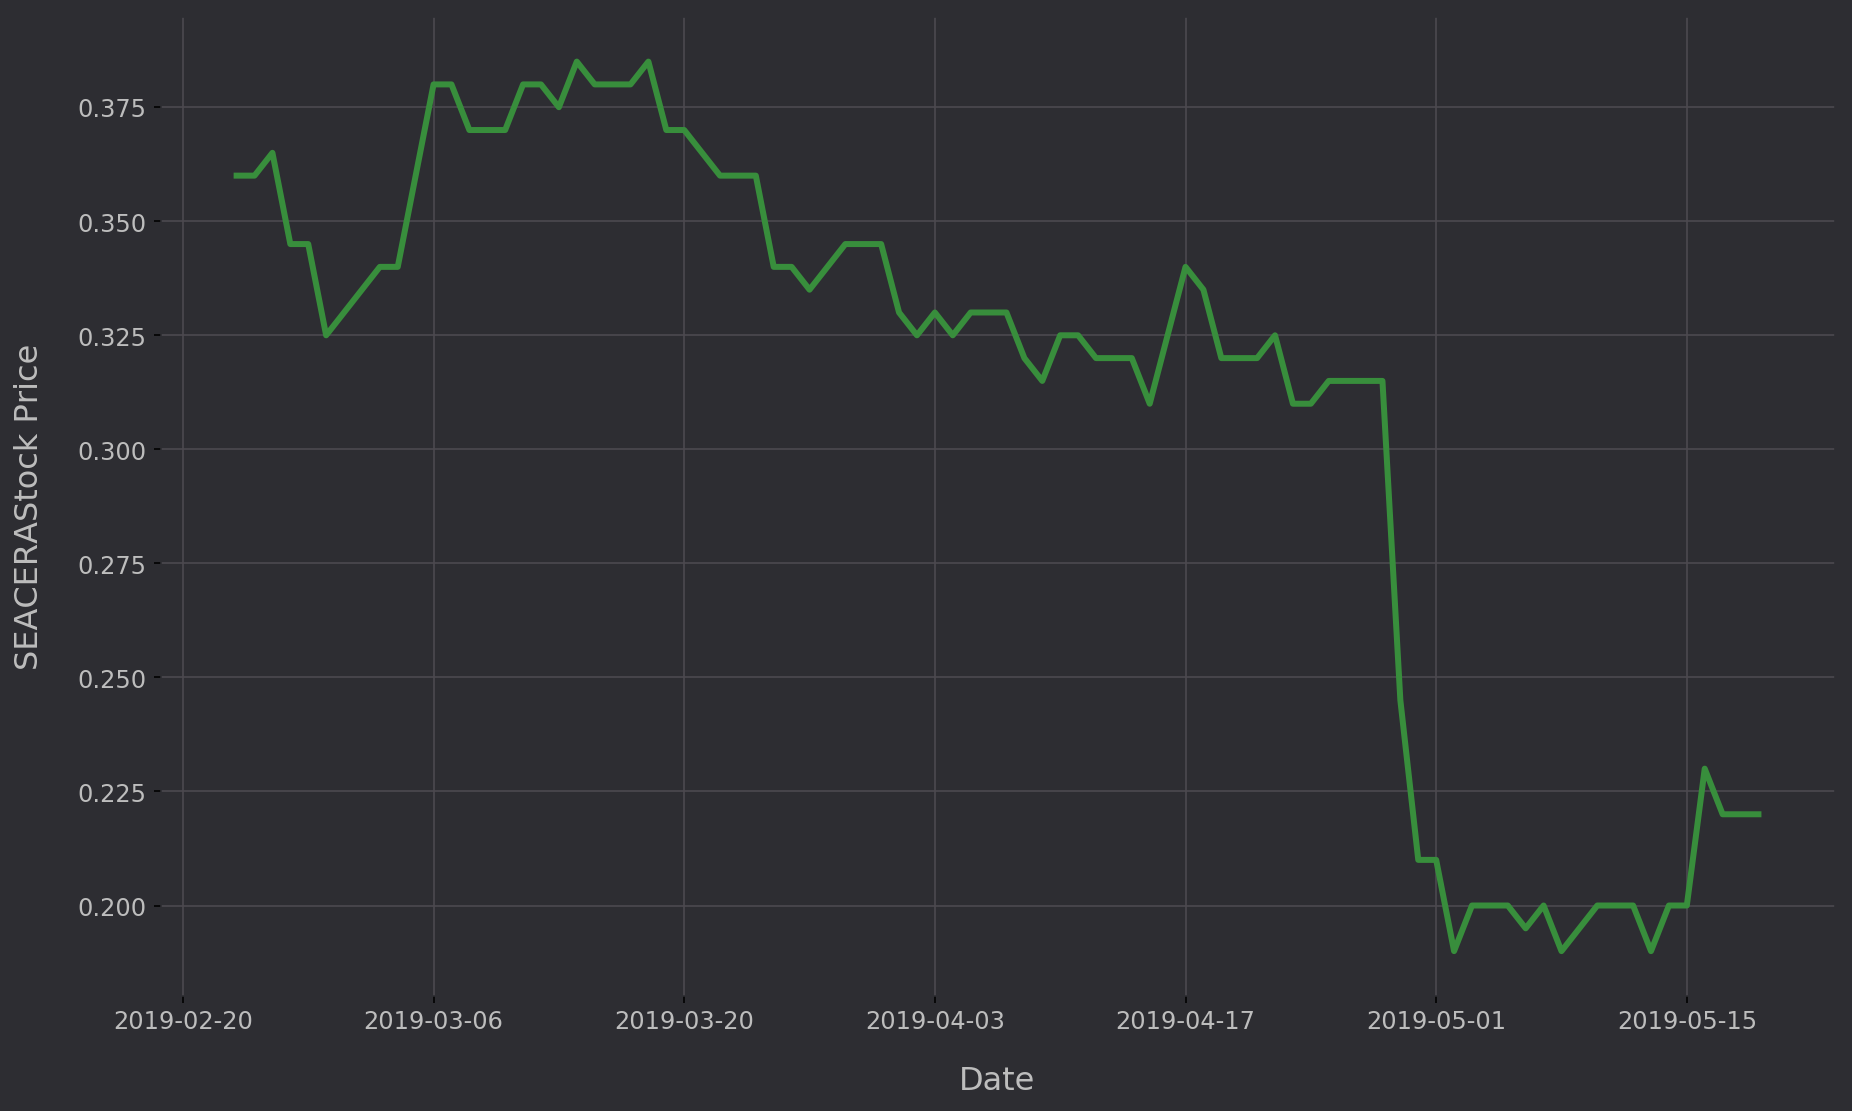

In [428]:
rec_col = ['#f4511e', '#ffb300', '#388e3c', 
           '#1976d2', '#9e9d24', '#b71c1c']
p_style = "style='font-size:18px; margin:2px 0; "\
          "font-family: \"CMU Sans Serif\"'"
i = 0
for name in stocks_of_interest:
    group = grouped.get_group(name)
    group.index = pd.to_datetime(group.date)
    co_info = company_info[company_info.company_symbol == name].squeeze()
    if len(co_info) > 0:
        i += 1
        if co_info.loc['shariah_compliant'] == 'Compliant':
            display(HTML(f"<p style='font-size:22px; "
                         "font-weight:bold; margin: 12px 0; "
                         "font-family: \"CMU Sans Serif\"'>" + str(i) +
                         ". " + name + "</p>"))
            display(HTML(f"<p {p_style}>Company Full Name: " + 
                         co_info.loc['company_full_name'] + "</p>"))
            display(HTML(f"<p {p_style}>Company Symbol: " + 
                         co_info.loc['company_symbol'] + "</p>"))
            display(HTML(f"<p {p_style}>Board: " + co_info.loc['board']
                         + "</p>"))
            display(HTML(f"<p {p_style}>Shariah Compliant Status: " +
                         co_info.loc['shariah_compliant'] + "</p>"))
            display(HTML(f"<p {p_style}>Sector: " + co_info.loc['sector'] 
                         + "</p>"))
            display(HTML(f"<p {p_style}>Sub-Sector: " + 
                         co_info.loc['sub_sector'] + "</p>"))
            display(HTML(f"<p {p_style}>" + name + " achieved " + 
                         co_info.loc['last_quarter_net_profit_000'] + 
                         "(000) in the quarter of " + 
                         co_info.loc['last_quarter'] + "</p>"))
            fig, ax1 = plt.subplots(figsize=(15, 9), facecolor=ax_facecolor);
            color=rec_col[i%6]
            ax1.set_facecolor(ax_facecolor)
            ax1.plot(group.last_price, color=color, linewidth=3);
            ax1.set_xlabel("Date", labelpad=16, fontsize=16, color='#bdbdbd');
            ax1.tick_params(axis='both', labelcolor='#bdbdbd')
            ax1.set_ylabel(name + "Stock Price", color='#bdbdbd', 
                           labelpad=16, fontsize=16)
            ax1.tick_params(axis='both', which='major', labelsize=12)
            ax1.grid(True, color='#4d4a50')
            ax1.spines['bottom'].set_color(ax_facecolor)
            ax1.spines['top'].set_color(ax_facecolor) 
            ax1.spines['right'].set_color(ax_facecolor)
            ax1.spines['left'].set_color(ax_facecolor)            
            display(fig);
            plt.close()
            display(HTML("<p style='font-size:20px; color:#b71c1c'>" + 
                         "*"*100 + "</p>"))
            

In [429]:
tweets = pd.read_csv('/Users/ammar/Documents/CS-and-work/UM MDatSc/3rd sem'
                     '/Data Mining/2nd Milestone/fullname_tweets.csv')

In [430]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: x[:70] + '...')

In [431]:
(tweets.head().style.set_table_styles(styles)
 .set_table_attributes('style="border-collapse: collapse"'))

,company_fullname,tweet_text,favorite_count,created_at,hashtags,tweet_id,lang,urls,user_followers,user_screen_name,crawling_time
0,AIRASIA X,RT @theworldindex: World's Best Low-Cost Airlines 2018: 1.🇲🇾 AirAsia ...,0,Mon Mar 11 23:52:05 +0000 2019,nan,1.10526e+18,en,nan,13770,alexisandmartin,2019-03-16|09:12
1,AIRASIA X,RT @theworldindex: World's Best Low-Cost Airlines 2018: 1.🇲🇾 AirAsia ...,0,Mon Mar 11 23:42:34 +0000 2019,nan,1.10525e+18,en,nan,528,AminSkywalker,2019-03-16|09:12
2,AIRASIA X,RT @theworldindex: World's Best Low-Cost Airlines 2018: 1.🇲🇾 AirAsia ...,0,Mon Mar 11 23:36:09 +0000 2019,nan,1.10525e+18,en,nan,193,ZiqaFrd,2019-03-16|09:12
3,AIRASIA X,RT @theworldindex: World's Best Low-Cost Airlines 2018: 1.🇲🇾 AirAsia ...,0,Mon Mar 11 23:33:49 +0000 2019,nan,1.10525e+18,en,nan,166,hanz_abd_manan,2019-03-16|09:12
4,AIRASIA X,RT @theworldindex: World's Best Low-Cost Airlines 2018: 1.🇲🇾 AirAsia ...,0,Mon Mar 11 23:33:38 +0000 2019,nan,1.10525e+18,en,nan,293,shahiraanadia,2019-03-16|09:12
